In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library

In [ ]:
!pip install rembg
!pip install onnxruntime

In [ ]:
import argparse
import cv2
import glob
import io
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from PIL import Image
from rembg import remove
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

# Preprocessing

### Rename, Remove Background, Crop and Resize

In [ ]:
# ---------------------------
# Konfigurasi
# ---------------------------
input_dir = '/content/drive/MyDrive/Kuning Telur - CV/Dataset'
output_dir = '/content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_YolkOnly'
os.makedirs(output_dir, exist_ok=True)

inset_ratio = 0.15
min_mask_pixels = 50
supported_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# ---------------------------
# Util
# ---------------------------
def sanitize_name(name):
    name = name.lower()
    name = re.sub(r'[^a-z0-9]+', '_', name)
    return name.strip('_')

def make_output_path(input_path, input_root, output_root, counter_dict):
    rel = os.path.relpath(input_path, input_root)
    rel_folder = os.path.dirname(rel)
    prefix_parts = [sanitize_name(p) for p in rel_folder.split(os.sep) if p]
    prefix = "_".join(prefix_parts) if prefix_parts else "root"
    key = rel_folder
    counter_dict[key] = counter_dict.get(key, 0) + 1
    idx = counter_dict[key]
    base_name = f"{prefix}_{idx}.png"
    out_path = os.path.join(output_root, rel_folder, base_name)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    return out_path

# ---------------------------
# Fungsi utama: remove bg
# ---------------------------
def remove_bg_keep_yolk(img_bgr):
    h, w = img_bgr.shape[:2]
    hsv_ranges = [
        (np.array([0, 60, 40]),  np.array([12, 255, 255])),
        (np.array([12, 60, 40]), np.array([30, 255, 255])),
        (np.array([30, 40, 40]), np.array([65, 255, 255])),
    ]
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = np.zeros((h,w), dtype=np.uint8)
    for lo, hi in hsv_ranges:
        mask = cv2.bitwise_or(mask, cv2.inRange(hsv, lo, hi))
    mask = cv2.GaussianBlur(mask, (7,7), 0)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7)))
    mask = cv2.medianBlur(mask, 5)

    # Kontur besar
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
        total_pixels = h * w
        selected_mask = np.zeros_like(mask)
        area_accum = 0
        for cnt in contours_sorted:
            cv2.drawContours(selected_mask, [cnt], -1, 255, -1)
            area_accum += cv2.contourArea(cnt)
            if area_accum / total_pixels > 0.001:
                break
        mask = selected_mask
    else:
        mask = np.zeros_like(mask)

    # Alpha channel
    if cv2.countNonZero(mask) < min_mask_pixels:
        return None
    b,g,r = cv2.split(img_bgr)
    alpha = (mask>0).astype(np.uint8)*255
    rgba = cv2.merge([b,g,r,alpha])
    return rgba

# ---------------------------
# Crop dan resize
# ---------------------------
def ensure_bounds(x1,y1,x2,y2,w,h):
    x1 = max(0, int(x1)); y1 = max(0, int(y1))
    x2 = min(w, int(x2)); y2 = min(h, int(y2))
    return x1,y1,x2,y2

def crop_inside_object_from_rgba(img_rgba, inset_ratio=0.15):
    if img_rgba is None: return None
    h, w = img_rgba.shape[:2]
    alpha = img_rgba[:,:,3]
    if cv2.countNonZero(alpha) < min_mask_pixels: return None
    contours, _ = cv2.findContours(alpha.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return None
    main_cnt = max(contours, key=cv2.contourArea)
    x0,y0,w0,h0 = cv2.boundingRect(main_cnt)
    cx, cy = x0 + w0//2, y0 + h0//2
    side = max(int(w0*(1-inset_ratio)), int(h0*(1-inset_ratio)), 10)
    x1 = cx - side//2; y1 = cy - side//2; x2 = x1 + side; y2 = y1 + side
    x1,y1,x2,y2 = ensure_bounds(x1,y1,x2,y2,w,h)
    crop = img_rgba[y1:y2, x1:x2].copy()
    crop = cv2.resize(crop, (256,256))
    return crop

counter_dict = {}
count_processed = 0
count_skipped_exist = 0
count_skipped_error = 0

for root, dirs, files in os.walk(input_dir):
    for fname in files:
        if not fname.lower().endswith(supported_ext):
            continue
        in_path = os.path.join(root, fname)
        out_path = make_output_path(in_path, input_dir, output_dir, counter_dict)

        if os.path.exists(out_path):
            print(f"Skip exist: {out_path}")
            count_skipped_exist += 1
            continue

        img = cv2.imread(in_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Skip error (gagal baca): {in_path}")
            count_skipped_error += 1
            continue

        rgba = remove_bg_keep_yolk(img)
        if rgba is None:
            print(f"Skip error (yolk tidak terdeteksi): {in_path}")
            count_skipped_error += 1
            continue

        cropped = crop_inside_object_from_rgba(rgba, inset_ratio=inset_ratio)
        if cropped is None:
            print(f"Skip error (crop gagal): {in_path}")
            count_skipped_error += 1
            continue

        cv2.imwrite(out_path, cropped)
        print("Saved:", out_path)
        count_processed += 1

print("Selesai.")
print(f"Processed: {count_processed}")
print(f"Skipped (exist): {count_skipped_exist}")
print(f"Skipped (error): {count_skipped_error}")


Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_YolkOnly/Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelur/kamera_440_480_lx_12_30_1_telur_ayam_petelur_1.png
Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_YolkOnly/Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelur/kamera_440_480_lx_12_30_1_telur_ayam_petelur_2.png
Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_YolkOnly/Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelur/kamera_440_480_lx_12_30_1_telur_ayam_petelur_3.png
Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_YolkOnly/Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelur/kamera_440_480_lx_12_30_1_telur_ayam_petelur_4.png
Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_YolkOnly/Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelur/kamera_440_480_lx_12_30_1_telur_ayam_petelur_5.png
Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_YolkOnly/K

### Crop and Finishing

In [ ]:
# ---------------------------
# Konfigurasi path
# ---------------------------
input_dir = '/content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_YolkOnly'
output_dir = '/content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final'
os.makedirs(output_dir, exist_ok=True)

# ---------------------------
# Fungsi untuk fokus telur puyuh
# ---------------------------
def clean_yolk_quail(img_bgr):
    h, w = img_bgr.shape[:2]
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    lower = np.array([10, 80, 50])
    upper = np.array([40, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return cv2.resize(img_bgr, (256, 256))  # fallback

    c = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(c)
    center = (int(x), int(y))
    radius = int(radius * 0.85)

    yolk_mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(yolk_mask, center, radius, 255, -1)
    masked = cv2.bitwise_and(img_bgr, img_bgr, mask=yolk_mask)

    x1 = max(0, int(center[0] - radius))
    y1 = max(0, int(center[1] - radius))
    x2 = min(w, int(center[0] + radius))
    y2 = min(h, int(center[1] + radius))
    crop = masked[y1:y2, x1:x2]

    cleaned = cv2.resize(crop, (256, 256))
    return cleaned

# ---------------------------
# Proses semua file
# ---------------------------
supported_ext = ('.jpg', '.jpeg', '.png', '.bmp')
count_processed = 0
count_skipped_exist = 0
count_skipped_error = 0

for root, dirs, files in os.walk(input_dir):
    for fname in files:
        if not fname.lower().endswith(supported_ext):
            continue

        in_path = os.path.join(root, fname)
        rel_path = os.path.relpath(in_path, input_dir)
        out_path = os.path.join(output_dir, os.path.splitext(rel_path)[0] + ".png")
        os.makedirs(os.path.dirname(out_path), exist_ok=True)

        if os.path.exists(out_path):
            print(f"Skip exist: {out_path}")
            count_skipped_exist += 1
            continue

        img = cv2.imread(in_path)
        if img is None:
            print(f"Skip error (gagal baca): {in_path}")
            count_skipped_error += 1
            continue

        try:
            result = clean_yolk_quail(img)
            cv2.imwrite(out_path, result)
            print("Saved:", out_path)
            count_processed += 1
        except Exception as e:
            print(f"Skip error (exception): {in_path} -> {e}")
            count_skipped_error += 1

print("Selesai.")
print(f"Processed: {count_processed}")
print(f"Skipped (exist): {count_skipped_exist}")
print(f"Skipped (error): {count_skipped_error}")

Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final/Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelur/kamera_440_480_lx_12_30_1_telur_ayam_petelur_1.png
Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final/Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelur/kamera_440_480_lx_12_30_1_telur_ayam_petelur_2.png
Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final/Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelur/kamera_440_480_lx_12_30_1_telur_ayam_petelur_3.png
Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final/Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelur/kamera_440_480_lx_12_30_1_telur_ayam_petelur_4.png
Skip exist: /content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final/Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelur/kamera_440_480_lx_12_30_1_telur_ayam_petelur_5.png
Skip exist: /content/drive/MyDrive/Kuning Tel

# Ekstraksi Fitur

### Histogram RGB

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# ---------------------------
# Konfigurasi
# ---------------------------
input_dir = '/content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final/Kamera 440 - 480 lx/12:30'
supported_ext = ('.png', '.jpg', '.jpeg')

# Mapping nama folder ke label singkat
label_mapping = {
    '1. Telur Ayam Petelur': 'Ayam Petelur',
    '2. Telur Bebek': 'Bebek',
    '3. Telur Puyuh': 'Puyuh'
}

# Ambil jam dan range dari path
path_parts = input_dir.split(os.sep)
jam = path_parts[-1]  # folder terakhir
range_lx = path_parts[-2].replace(' ', '')  # folder sebelumnya, hapus spasi

# ---------------------------
# Fungsi ekstraksi histogram RGB
# ---------------------------
def extract_rgb_histogram(image_path, bins=256):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Buat mask: pixel hitam (0,0,0) diabaikan
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)[1]  # pixel > 0 dianggap valid

    hist_r = cv2.calcHist([image_rgb], [0], mask, [bins], [0,256]).flatten()
    hist_g = cv2.calcHist([image_rgb], [1], mask, [bins], [0,256]).flatten()
    hist_b = cv2.calcHist([image_rgb], [2], mask, [bins], [0,256]).flatten()

    return hist_r, hist_g, hist_b

# ---------------------------
# Proses setiap folder
# ---------------------------
hist_data = {}  # simpan rata-rata histogram per jenis telur

for folder_name in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder_name)
    if os.path.isdir(folder_path):
        short_label = label_mapping.get(folder_name, folder_name)
        avg_r, avg_g, avg_b = np.zeros(256), np.zeros(256), np.zeros(256)
        count = 0

        for file_name in os.listdir(folder_path):
            if file_name.lower().endswith(supported_ext):
                file_path = os.path.join(folder_path, file_name)
                hist = extract_rgb_histogram(file_path)
                if hist is not None:
                    r, g, b = hist
                    avg_r += r
                    avg_g += g
                    avg_b += b
                    count += 1

        if count > 0:
            avg_r /= count
            avg_g /= count
            avg_b /= count
            hist_data[short_label] = (avg_r, avg_g, avg_b)

# ---------------------------
# Simpan ke CSV
# ---------------------------
rows = []
for label, (r, g, b) in hist_data.items():
    for i in range(256):  # tiap bin histogram
        rows.append({
            "Label": label,
            "Bin": i,
            "R": r[i],
            "G": g[i],
            "B": b[i]
        })

df = pd.DataFrame(rows)

# Pastikan folder output ada
output_dir = "/content/drive/MyDrive/Kuning Telur - CV/Ekstraksi/HistogramRGB"
os.makedirs(output_dir, exist_ok=True)

# Nama file: 440_1230.csv
output_file = os.path.join(output_dir, "440_1230.csv")
df.to_csv(output_file, index=False)

print(f"Hasil histogram berhasil disimpan ke {output_file}")


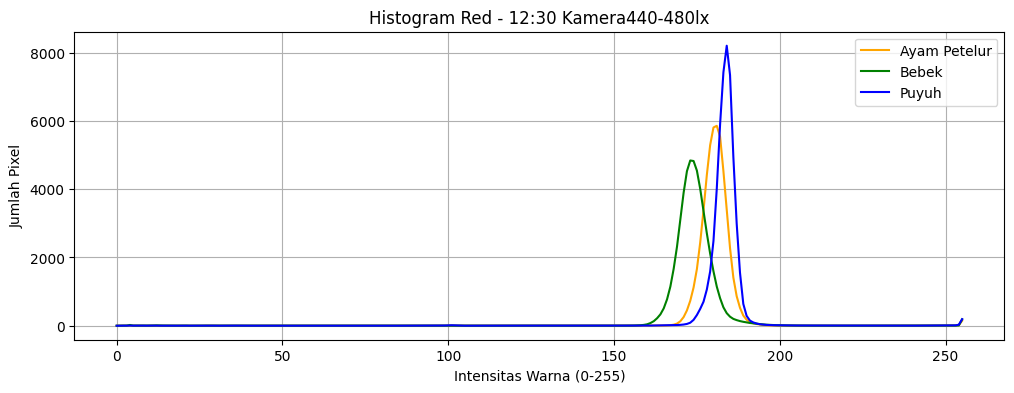

In [ ]:
bins = np.arange(256)

plt.figure(figsize=(12,4))
color_map = {
    'Ayam Petelur': 'orange',  # Telur Ayam
    'Bebek': 'green',   # Telur Bebek
    'Puyuh': 'blue'     # Telur Puyuh
}

for label, (r, g, b) in hist_data.items():
    color = color_map.get(label, 'black')
    plt.plot(bins, r, label=label, color=color)

plt.title(f'Histogram Red - {jam} {range_lx}')
plt.xlabel('Intensitas Warna (0-255)')
plt.ylabel('Jumlah Pixel')
plt.grid(True)
plt.legend()
plt.show()


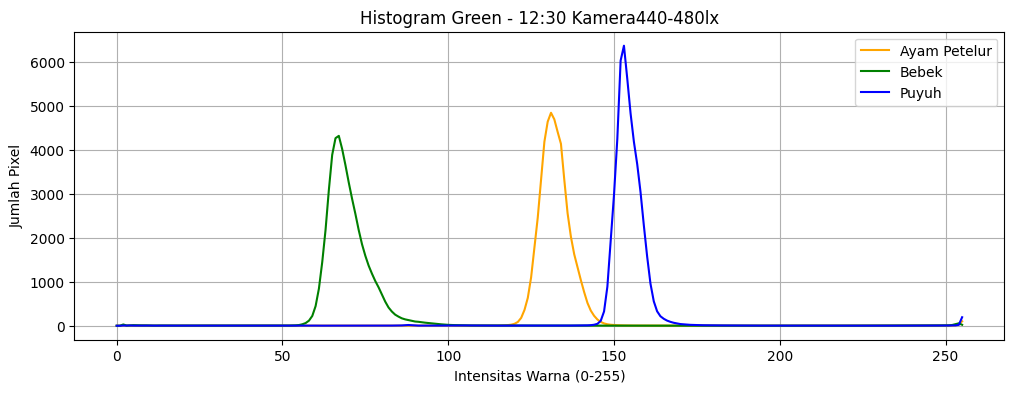

In [ ]:
plt.figure(figsize=(12,4))
for label, (r, g, b) in hist_data.items():
    color = color_map.get(label, 'black')
    plt.plot(bins, g, label=label, color=color)

plt.title(f'Histogram Green - {jam} {range_lx}')
plt.xlabel('Intensitas Warna (0-255)')
plt.ylabel('Jumlah Pixel')
plt.grid(True)
plt.legend()
plt.show()


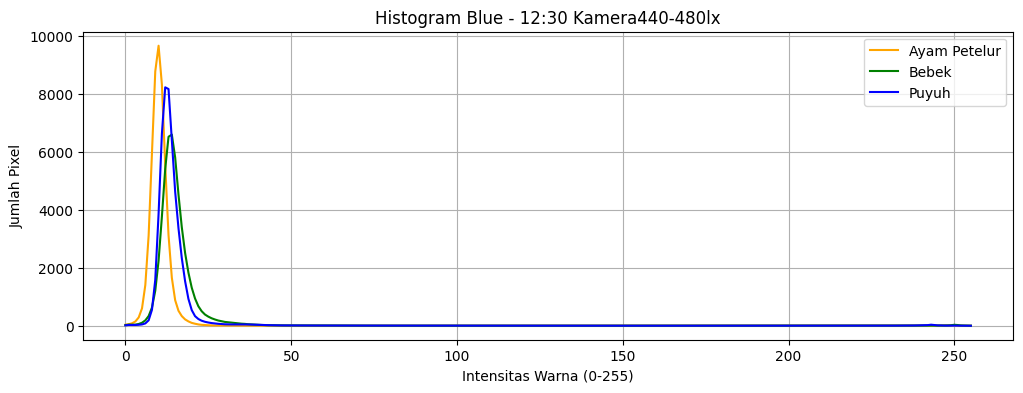

In [ ]:
plt.figure(figsize=(12,4))
for label, (r, g, b) in hist_data.items():
    color = color_map.get(label, 'black')
    plt.plot(bins, b, label=label, color=color)

plt.title(f'Histogram Blue - {jam} {range_lx}')
plt.xlabel('Intensitas Warna (0-255)')
plt.ylabel('Jumlah Pixel')
plt.grid(True)
plt.legend()
plt.show()


### RGB Means

In [ ]:
# ---------------------------
# Konfigurasi
# ---------------------------
input_dir = '/content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final/Kamera 920 - 960 lx/15:00'
output_csv = '/content/drive/MyDrive/Kuning Telur - CV/Ekstraksi/RGBMeans/920_1500.csv'
supported_ext = ('.png', '.jpg', '.jpeg')

# Mapping nama folder ke label singkat
label_mapping = {
    'Telur Ayam': 'AP',
    'Telur Bebek': 'BP',
    'Telur Puyuh': 'QP'
}

# ---------------------------
# Ambil jam dan range dari path
# ---------------------------
path_parts = input_dir.split(os.sep)
jam = path_parts[-1]  # folder terakhir
range_lx = path_parts[-2]  # folder sebelumnya

# ---------------------------
# Fungsi ekstraksi RGB rata-rata
# ---------------------------
def extract_rgb_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    r_mean = np.mean(image_rgb[:, :, 0])
    g_mean = np.mean(image_rgb[:, :, 1])
    b_mean = np.mean(image_rgb[:, :, 2])
    return [r_mean, g_mean, b_mean]

# ---------------------------
# Proses setiap folder di input_dir
# ---------------------------
data = []

for folder_name in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder_name)
    if os.path.isdir(folder_path):
        # Ambil label singkat
        short_label = label_mapping.get(folder_name, folder_name)
        final_label = f"{short_label}_{jam}_{range_lx.replace(' ', '')}"  # hapus spasi

        rgb_values = []
        for file_name in os.listdir(folder_path):
            if file_name.lower().endswith(supported_ext):
                file_path = os.path.join(folder_path, file_name)
                features = extract_rgb_features(file_path)
                if features is not None:
                    rgb_values.append(features)

        # Rata-rata semua gambar dalam folder
        if rgb_values:
            rgb_avg = np.mean(rgb_values, axis=0)
            data.append(list(rgb_avg) + [final_label])

# ---------------------------
# Simpan ke CSV
# ---------------------------
columns = ['R_mean', 'G_mean', 'B_mean', 'Label']
df = pd.DataFrame(data, columns=columns)
df.to_csv(output_csv, index=False)
print(f"Ekstraksi selesai! Data rata-rata per label tersimpan di {output_csv}")


Ekstraksi selesai! Data rata-rata per label tersimpan di /content/drive/MyDrive/Kuning Telur - CV/Ekstraksi/RGBMeans/920_1500.csv


In [ ]:
# ---------------------------
# Folder tempat CSV berada
# ---------------------------
csv_dir = '/content/drive/MyDrive/Kuning Telur - CV/Ekstraksi/RGBMeans'
csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))

# ---------------------------
# List untuk menampung semua data
# ---------------------------
all_data = []

for file in csv_files:
    df = pd.read_csv(file)

    # Ekstrak jam dan lux dari Label
    # Contoh Label: "1. Telur Ayam Petelur_13:00_Kamera440-480lx"
    df[['Label_Telur', 'Jam', 'Kamera']] = df['Label'].str.split('_', expand=True)

    # Bersihkan Label_Telur (hapus nomor urut)
    df['Label_Telur'] = df['Label_Telur'].str.replace(r'^\d+\.\s*', '', regex=True)

    # Bersihkan Kamera, ambil cuma angka + rentang
    df['Kamera'] = df['Kamera'].str.replace('Kamera', '').str.replace('lx', '')

    # Pilih kolom yang penting untuk long format
    df_long = df[['Jam', 'Kamera', 'Label_Telur', 'R_mean', 'G_mean', 'B_mean']]

    # Tambahkan ke list
    all_data.append(df_long)

# ---------------------------
# Gabungkan semua CSV
# ---------------------------
df_all = pd.concat(all_data, ignore_index=True)

# Tampilkan 10 baris pertama
print(df_all.head(100))

      Jam   Kamera         Label_Telur      R_mean      G_mean     B_mean
0   12:30  440-480  Telur Ayam Petelur  141.922257  104.297500   8.929024
1   12:30  440-480         Telur Bebek  137.123973   55.628127  12.838411
2   12:30  440-480         Telur Puyuh  144.629034  122.011378  12.252704
3   13:00  440-480  Telur Ayam Petelur  140.107163  102.053424   8.824187
4   13:00  440-480         Telur Bebek  137.371135   55.350405  13.516827
5   13:00  440-480         Telur Puyuh  142.957565  119.993349  10.854306
6   13:30  440-480  Telur Ayam Petelur  139.488192  100.859559   8.984599
7   13:30  440-480         Telur Bebek  137.930004   55.826147  13.581388
8   13:30  440-480         Telur Puyuh  151.134973  127.646143  13.067278
9   14:00  440-480  Telur Ayam Petelur  141.946680  102.708553   9.161798
10  14:00  440-480         Telur Bebek  137.118634   53.633920  11.283900
11  14:00  440-480         Telur Puyuh  144.985641  122.026412   9.834165
12  14:30  440-480  Telur Ayam Petelur

#### Perbandingan RGB means Berdasarkan Jenis dan Intensitas Cahaya




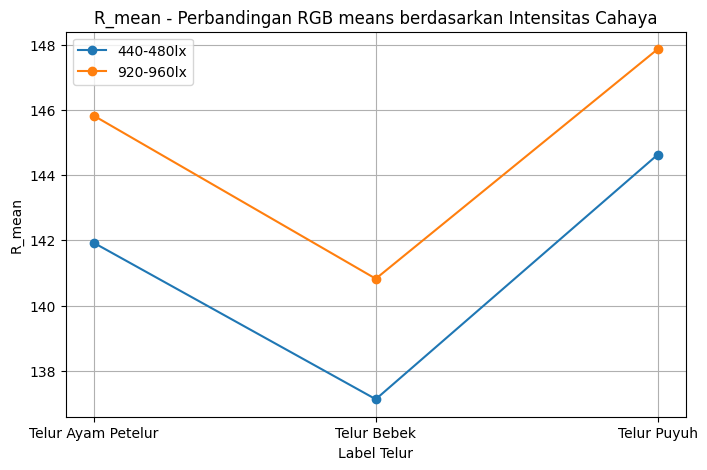

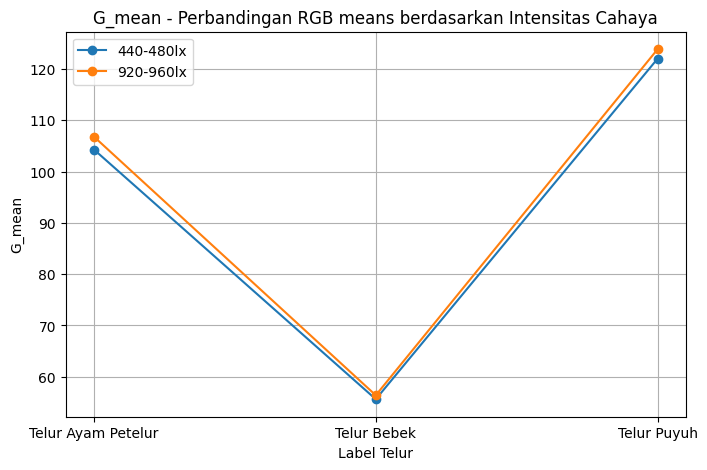

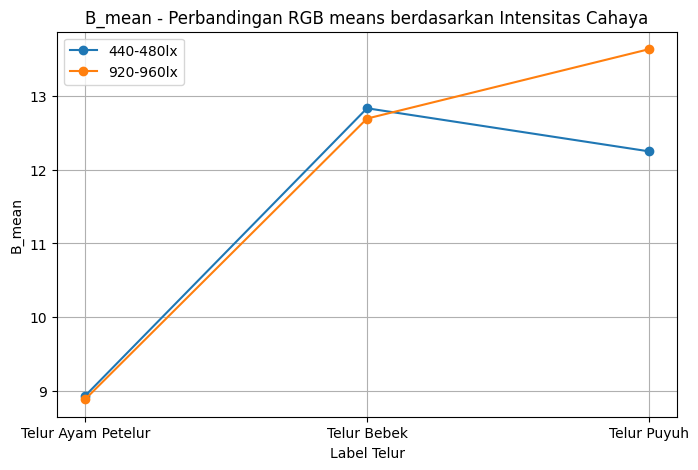

In [ ]:
channels = ['R_mean', 'G_mean', 'B_mean']
lux_list = df_all['Kamera'].unique()
labels = df_all['Label_Telur'].unique()

for channel in channels:
    plt.figure(figsize=(8,5))

    for lux in lux_list:
        df_plot = df_all[df_all['Kamera'] == lux]
        means = [df_plot[df_plot['Label_Telur'] == label][channel].values[0] for label in labels]
        plt.plot(labels, means, marker='o', label=f'{lux}lx')

    plt.title(f'{channel} - Perbandingan RGB means berdasarkan Intensitas Cahaya')
    plt.ylabel(channel)
    plt.xlabel('Label Telur')
    plt.grid(True)
    plt.legend()
    plt.show()

#### Perbandingan nilai RGB seiring waktu

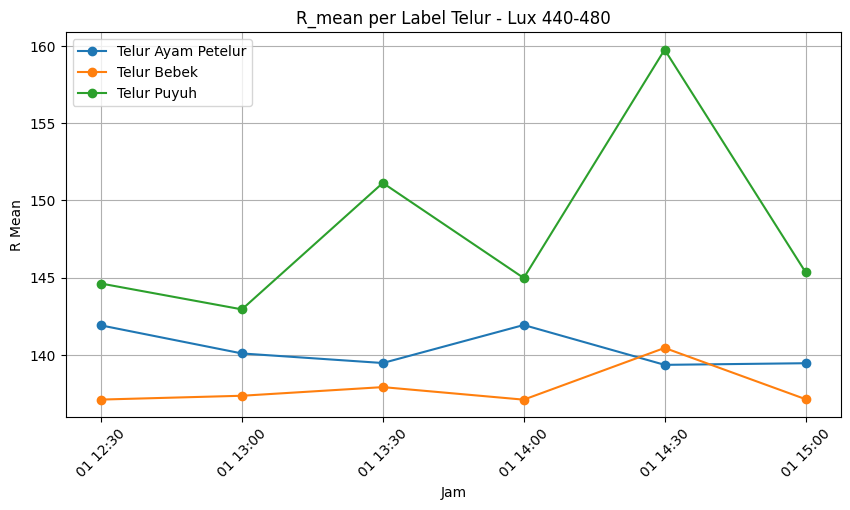

In [ ]:
df_all['Jam'] = pd.to_datetime(df_all['Jam'], format='%H:%M')
lux = '440-480'
labels = df_all['Label_Telur'].unique()
df_lux = df_all[df_all['Kamera'] == lux]

plt.figure(figsize=(10,5))
for label in labels:
    df_plot = df_lux[df_lux['Label_Telur'] == label].sort_values('Jam')
    plt.plot(df_plot['Jam'], df_plot['R_mean'], marker='o', linestyle='-', label=label)

plt.title(f'R_mean per Label Telur - Lux {lux}')
plt.xlabel('Jam')
plt.ylabel('R Mean')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


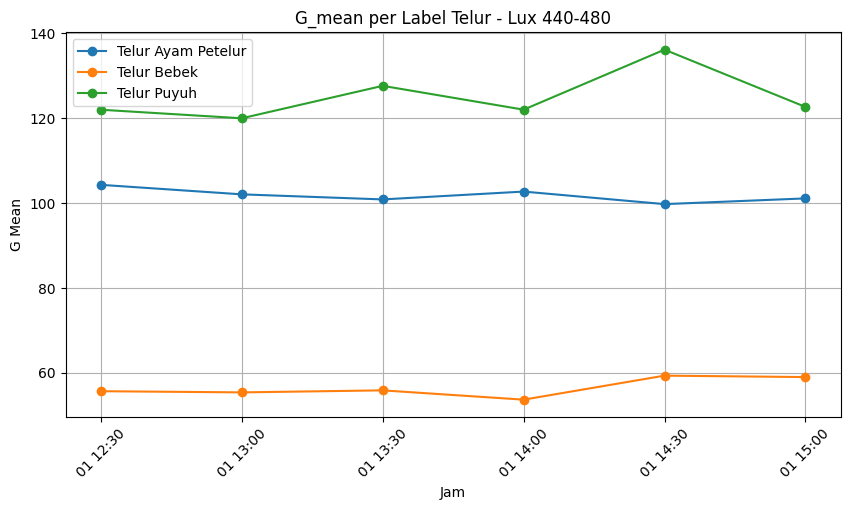

In [ ]:
plt.figure(figsize=(10,5))
for label in labels:
    df_plot = df_lux[df_lux['Label_Telur'] == label].sort_values('Jam')
    plt.plot(df_plot['Jam'], df_plot['G_mean'], marker='o', linestyle='-', label=label)

plt.title(f'G_mean per Label Telur - Lux {lux}')
plt.xlabel('Jam')
plt.ylabel('G Mean')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


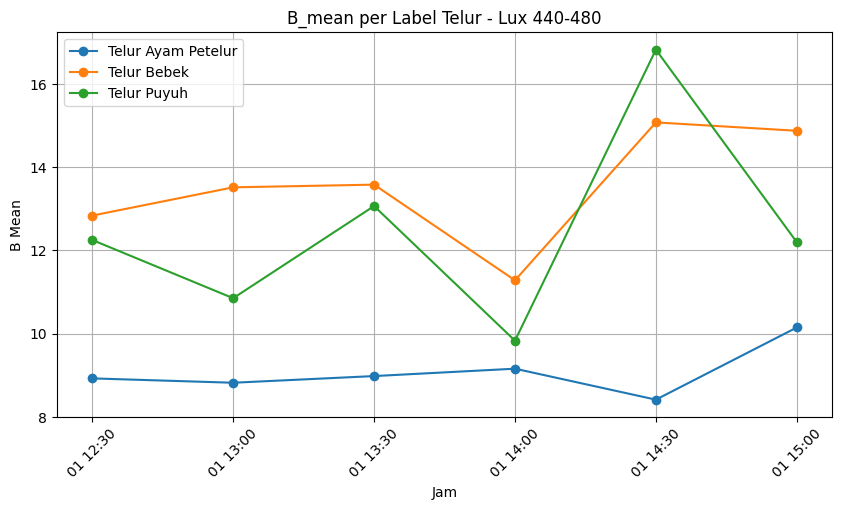

In [ ]:
plt.figure(figsize=(10,5))
for label in labels:
    df_plot = df_lux[df_lux['Label_Telur'] == label].sort_values('Jam')
    plt.plot(df_plot['Jam'], df_plot['B_mean'], marker='o', linestyle='-', label=label)

plt.title(f'B_mean per Label Telur - Lux {lux}')
plt.xlabel('Jam')
plt.ylabel('B Mean')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


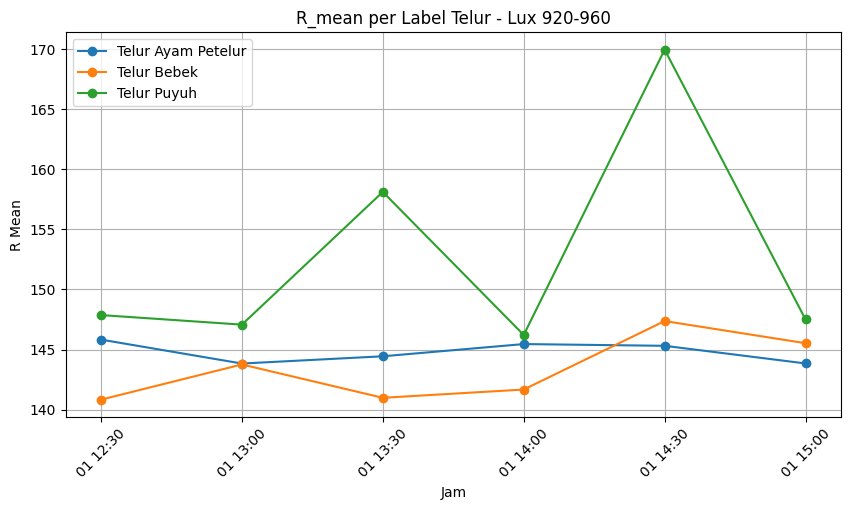

In [ ]:
lux = '920-960'
df_lux = df_all[df_all['Kamera'] == lux]

plt.figure(figsize=(10,5))
for label in labels:
    df_plot = df_lux[df_lux['Label_Telur'] == label].sort_values('Jam')
    plt.plot(df_plot['Jam'], df_plot['R_mean'], marker='o', linestyle='-', label=label)

plt.title(f'R_mean per Label Telur - Lux {lux}')
plt.xlabel('Jam')
plt.ylabel('R Mean')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


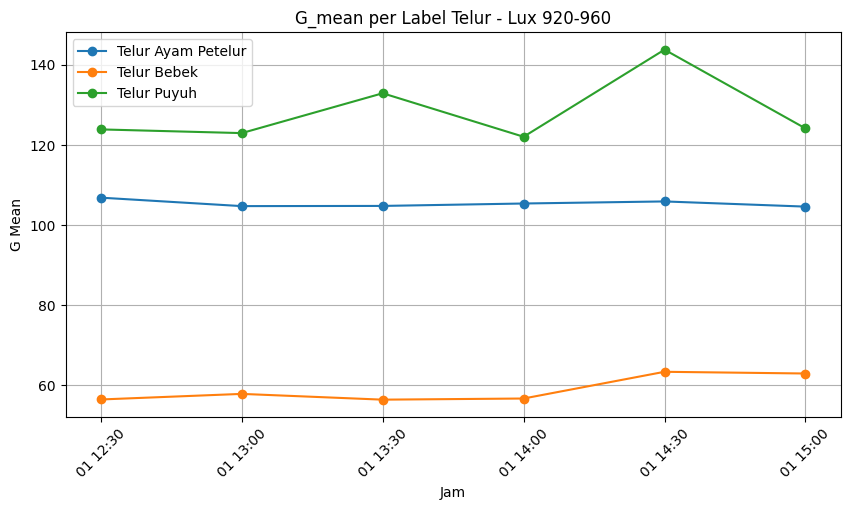

In [ ]:
lux = '920-960'
df_lux = df_all[df_all['Kamera'] == lux]

plt.figure(figsize=(10,5))
for label in labels:
    df_plot = df_lux[df_lux['Label_Telur'] == label].sort_values('Jam')
    plt.plot(df_plot['Jam'], df_plot['G_mean'], marker='o', linestyle='-', label=label)

plt.title(f'G_mean per Label Telur - Lux {lux}')
plt.xlabel('Jam')
plt.ylabel('G Mean')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

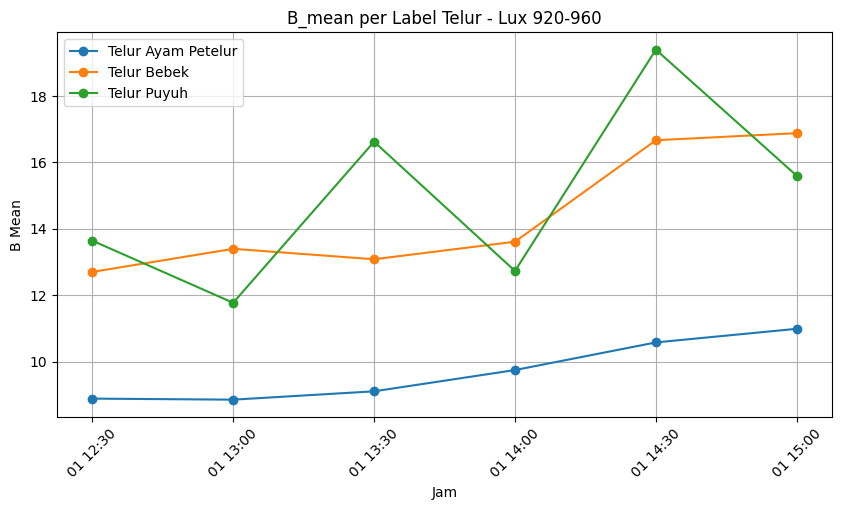

In [ ]:
lux = '920-960'
df_lux = df_all[df_all['Kamera'] == lux]

plt.figure(figsize=(10,5))
for label in labels:
    df_plot = df_lux[df_lux['Label_Telur'] == label].sort_values('Jam')
    plt.plot(df_plot['Jam'], df_plot['B_mean'], marker='o', linestyle='-', label=label)

plt.title(f'B_mean per Label Telur - Lux {lux}')
plt.xlabel('Jam')
plt.ylabel('B Mean')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

Menampilkan Grafik 1: Perubahan Warna Seiring Waktu...


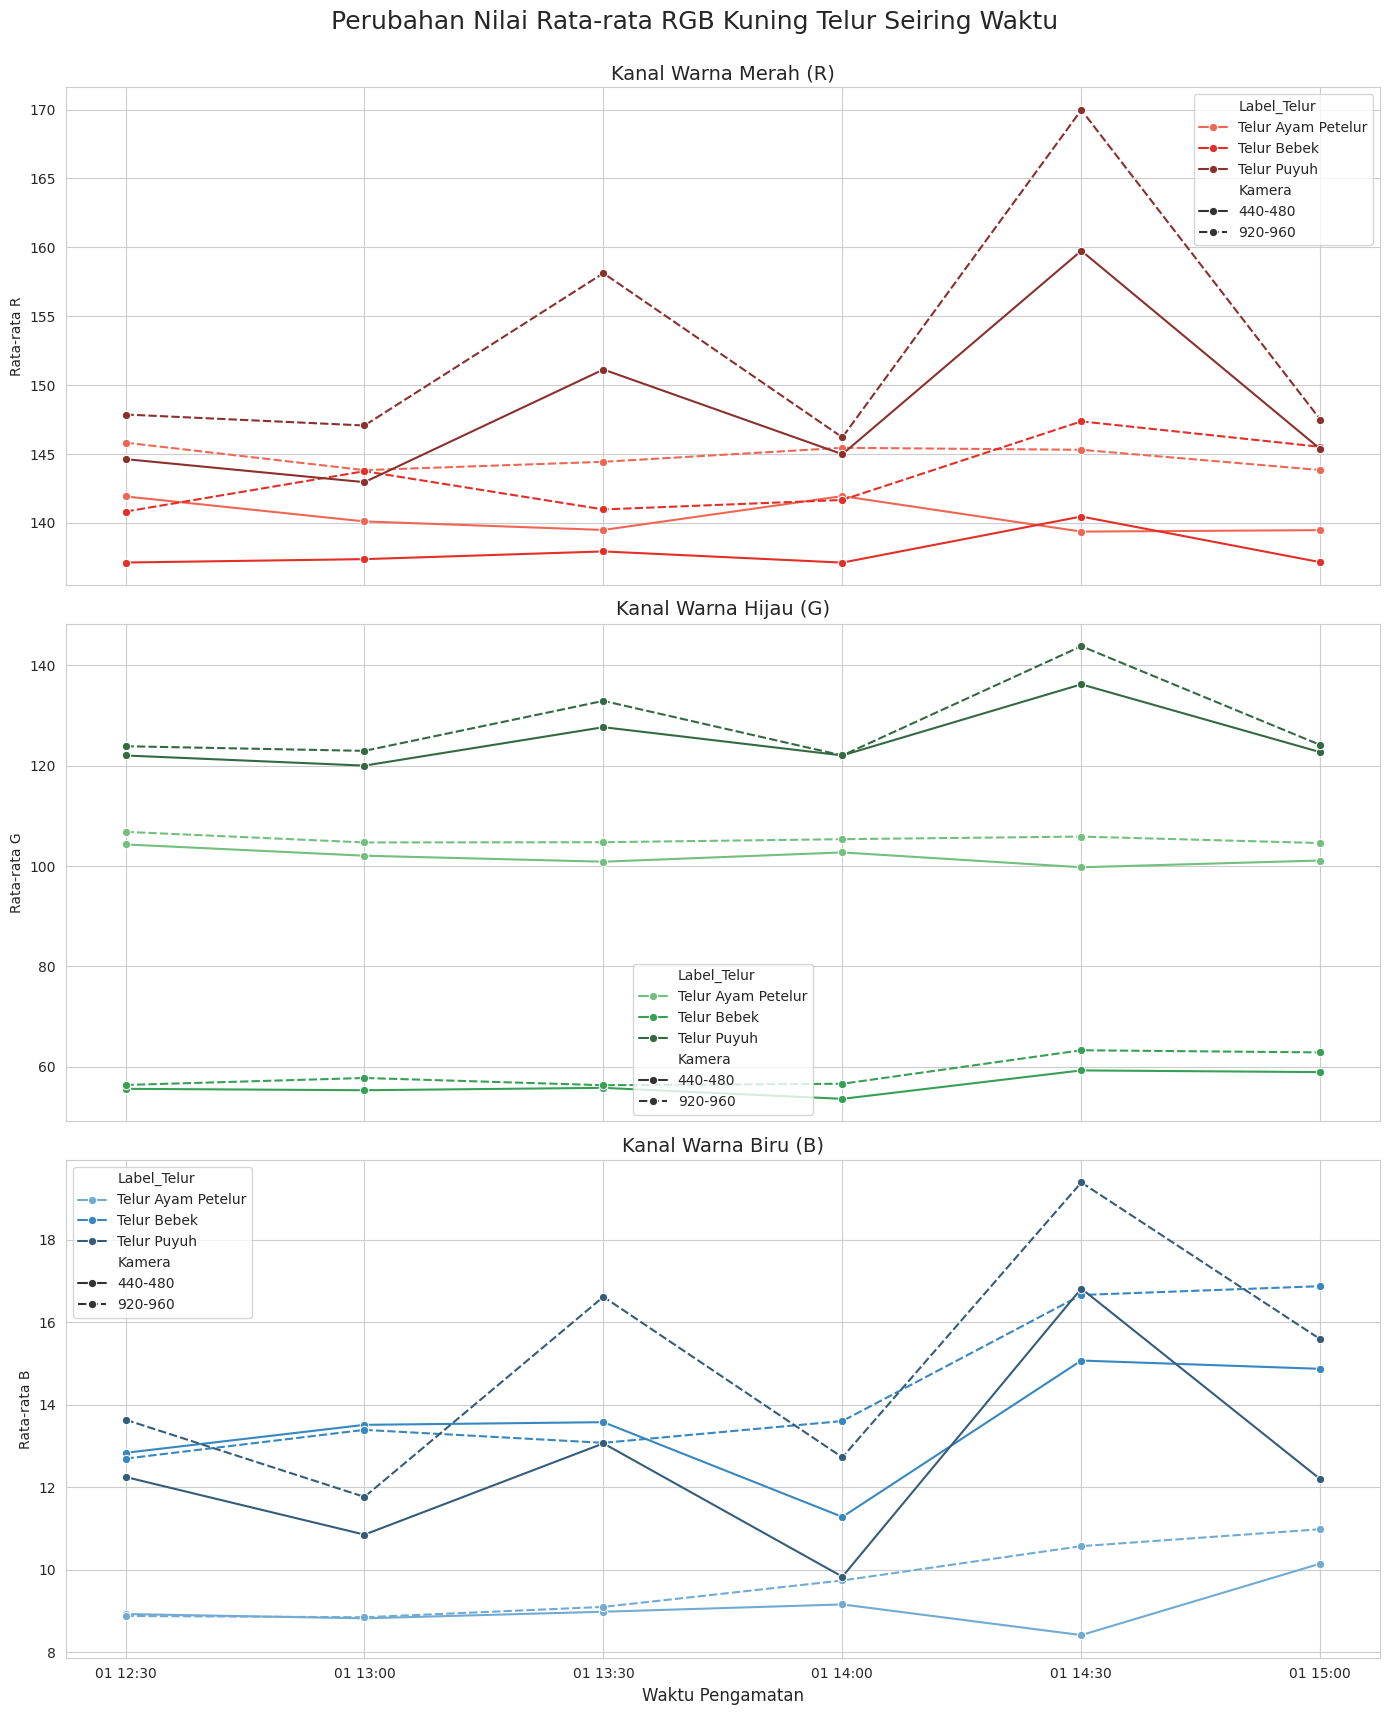


Menampilkan Grafik 2: Perbandingan Rata-rata Warna Keseluruhan...


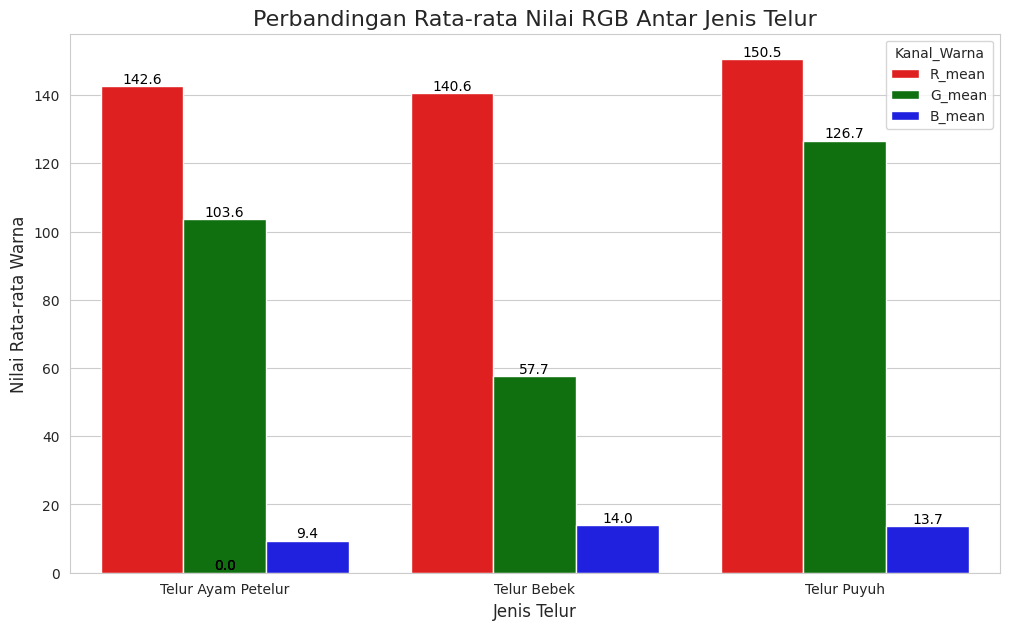

In [ ]:
# 1. Menyiapkan Data
data = df_all

# Use the existing DataFrame and convert 'Jam' to datetime again
df_all['Jam'] = pd.to_datetime(df_all['Jam'], format='%H:%M')
df = df_all.copy()


# Mengatur style plot agar lebih menarik
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

# ---
# Grafik 1: Line Chart - Perubahan Warna RGB Seiring Waktu
# ---
print("Menampilkan Grafik 1: Perubahan Warna Seiring Waktu...")

fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
fig.suptitle('Perubahan Nilai Rata-rata RGB Kuning Telur Seiring Waktu', fontsize=18, y=0.95)

# Plot untuk R_mean
sns.lineplot(ax=axes[0], data=df, x='Jam', y='R_mean', hue='Label_Telur', style='Kamera', marker='o', palette='Reds_d')
axes[0].set_title('Kanal Warna Merah (R)', fontsize=14)
axes[0].set_ylabel('Rata-rata R')

# Plot untuk G_mean
sns.lineplot(ax=axes[1], data=df, x='Jam', y='G_mean', hue='Label_Telur', style='Kamera', marker='o', palette='Greens_d')
axes[1].set_title('Kanal Warna Hijau (G)', fontsize=14)
axes[1].set_ylabel('Rata-rata G')

# Plot untuk B_mean
sns.lineplot(ax=axes[2], data=df, x='Jam', y='B_mean', hue='Label_Telur', style='Kamera', marker='o', palette='Blues_d')
axes[2].set_title('Kanal Warna Biru (B)', fontsize=14)
axes[2].set_ylabel('Rata-rata B')
axes[2].set_xlabel('Waktu Pengamatan', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ---
# Grafik 2: Bar Chart - Perbandingan Rata-rata Warna Antar Jenis Telur
# ---
print("\nMenampilkan Grafik 2: Perbandingan Rata-rata Warna Keseluruhan...")

# Hitung rata-rata keseluruhan untuk setiap jenis telur
df_mean = df.groupby('Label_Telur')[['R_mean', 'G_mean', 'B_mean']].mean().reset_index()

# Ubah format data (melt) agar mudah diplot dengan seaborn
df_melted = pd.melt(df_mean, id_vars='Label_Telur', var_name='Kanal_Warna', value_name='Nilai_Rata_Rata')

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=df_melted, x='Label_Telur', y='Nilai_Rata_Rata', hue='Kanal_Warna', palette={'R_mean':'red', 'G_mean':'green', 'B_mean':'blue'})
plt.title('Perbandingan Rata-rata Nilai RGB Antar Jenis Telur', fontsize=16)
plt.xlabel('Jenis Telur', fontsize=12)
plt.ylabel('Nilai Rata-rata Warna', fontsize=12)

# Tambahkan label angka di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


Analisis menunjukkan bahwa ketiga jenis telur memiliki profil warna yang khas dan dapat dibedakan secara signifikan, terutama Telur Bebek yang memiliki karakteristik warna paling unik. Telur Puyuh secara konsisten menjadi yang paling cerah (kuning paling terang), sementara Telur Ayam Petelur berada di posisi tengah. Terlihat ada tren perubahan warna yang subtil seiring waktu, dan terdapat perbedaan sistematis antara kedua kamera yang digunakan, di mana kamera '920-960' cenderung merekam warna yang sedikit lebih intens.
<br><br>
Jika kita merata-ratakan semua data waktu dan intensitas cahaya, kita mendapatkan profil warna dasar untuk setiap jenis telur:
1. Telur Puyuh: Memiliki nilai R_mean (merah) dan G_mean (hijau) tertinggi di antara ketiganya. Tingginya nilai G secara khusus menunjukkan warna kuning yang paling cerah dan vibrant. Ini adalah kuning telur "klasik" yang paling terang.
2. Telur Ayam Petelur: Memiliki profil warna yang seimbang, berada di antara telur puyuh dan bebek. Nilai R dan G-nya lebih rendah dari puyuh, menghasilkan warna kuning standar.
3. Telur Bebek: Profilnya sangat unik karena memiliki nilai G_mean (hijau) yang jauh paling rendah. Rendahnya komponen hijau dibandingkan dengan komponen merahnya menghasilkan warna yang lebih pekat, cenderung oranye tua atau kuning kemerahan.

<br><br>
**Analisis Tren Perubahan Warna Seiring Waktu**
<br>
Dari grafik garis yang dihasilkan sebelumnya, kita dapat mengamati:
1. Secara umum, perubahan warna pada semua jenis telur tidak drastis dalam rentang waktu 2.5 jam. Nilai RGB relatif stabil.
2. Terlihat ada sedikit kenaikan pada nilai R, G, dan B untuk Telur Puyuh dan Bebek, terutama pada pengukuran di jam-jam terakhir (14:30 - 15:00).
3. Ini mungkin terjadi karena pigmen warnanya berubah, atau karena permukaan kuning telur mulai sedikit mengering.mpak lebih cerah atau lebih jenuh oleh sensor kamera.
4. Warna telur ayam petelur menunjukkan perubahan paling kecil dan cenderung paling stabil dari waktu ke waktu.
5. Gambar dengan intensitas cahaya '920-960' secara konsisten merekam nilai R, G, dan B yang sedikit lebih tinggi dibandingkan '440-480' untuk semua jenis telur pada waktu yang sama. Yang berarti ada pengaruh intensitas cahaya di ruangan dengan hasil pengambilan gambar.

## GLCM

In [ ]:
import skimage
print(skimage.__version__)


0.25.2


In [ ]:
from skimage.feature import graycomatrix, graycoprops

# === Konfigurasi ===
input_dir = '/content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final/'
output_csv = '/content/drive/MyDrive/Kuning Telur - CV/Ekstraksi/glcm_features.csv'


def extract_glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # quantisasi 8 level biar GLCM tidak terlalu besar
    gray = (gray / 32).astype(np.uint8)

    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(gray,
                        distances=distances,
                        angles=angles,
                        levels=8,
                        symmetric=True,
                        normed=True)

    features = {}
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    for prop in props:
        values = graycoprops(glcm, prop)
        features[prop] = values.mean()

    return features

# === Loop semua file di subfolder ===
all_features = []

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(root, file)
            image = cv2.imread(file_path)

            if image is None:
                print(f"Gagal membaca gambar: {file_path}")
                continue

            glcm_features = extract_glcm_features(image)
            glcm_features['filename'] = file
            glcm_features['folder'] = os.path.basename(root)  # simpan nama folder juga

            all_features.append(glcm_features)

# === Simpan ke CSV ===
df = pd.DataFrame(all_features)
df.to_csv(output_csv, index=False)

print(f"Total {len(df)} gambar berhasil diproses.")
print(f"CSV disimpan di: {output_csv}")

Total 2160 gambar berhasil diproses.
CSV disimpan di: /content/drive/MyDrive/Kuning Telur - CV/Ekstraksi/glcm_features.csv


In [ ]:
pd.read_csv('/content/drive/MyDrive/Kuning Telur - CV/Ekstraksi/glcm_features.csv')


,contrast,dissimilarity,homogeneity,ASM,energy,correlation,filename,folder
0,0.318744,0.188675,0.917561,0.418835,0.647164,0.938481,kamera_440_480_lx_12_30_1_telur_ayam_petelur_1...,1. Telur Ayam Petelur
1,0.318950,0.186058,0.919104,0.423471,0.650736,0.938532,kamera_440_480_lx_12_30_1_telur_ayam_petelur_2...,1. Telur Ayam Petelur
2,0.319557,0.187976,0.918039,0.414846,0.644074,0.938268,kamera_440_480_lx_12_30_1_telur_ayam_petelur_3...,1. Telur Ayam Petelur
3,0.312280,0.180943,0.921532,0.433601,0.658473,0.939869,kamera_440_480_lx_12_30_1_telur_ayam_petelur_4...,1. Telur Ayam Petelur
4,0.318725,0.187639,0.918171,0.419313,0.647533,0.938508,kamera_440_480_lx_12_30_1_telur_ayam_petelur_5...,1. Telur Ayam Petelur
...,...,...,...,...,...,...,...,...
2155,0.198776,0.071940,0.975414,0.606948,0.779064,0.962242,kamera_920_960_lx_15_00_3_telur_puyuh_56.png,3. Telur Puyuh
2156,0.201782,0.073531,0.974765,0.599940,0.774553,0.962247,kamera_920_960_lx_15_00_3_telur_puyuh_57.png,3. Telur Puyuh
2157,0.190613,0.067938,0.977064,0.625122,0.790643,0.962724,kamera_920_960_lx_15_00_3_telur_puyuh_58.png,3. Telur Puyuh
2158,0.190854,0.068074,0.976982,0.625360,0.790793,0.962579,kamera_920_960_lx_15_00_3_telur_puyuh_59.png,3. Telur Puyuh


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Kuning Telur - CV/Ekstraksi/glcm_features.csv")

mapping_telur = {
    "telur_puyuh": "Puyuh",
    "telur_ayam_petelur": "Ayam Petelur",
    "telur_bebek": "Bebek"
}

def parse_filename(fname):
    parts = fname.split("_")
    kamera = f"{parts[1]}_{parts[2]}"   # contoh: 920_960
    jam = f"{parts[4]}:{parts[5]}"      # contoh: 15:00
    telur_key = "_".join(parts[7:-1])   # contoh: telur_puyuh, telur_ayam_petelur
    label_telur = mapping_telur.get(telur_key, "Unknown")
    return jam, kamera, label_telur

df[["Jam", "Kamera", "Label_Telur"]] = df["filename"].apply(
    lambda x: pd.Series(parse_filename(x))
)

cols = ["Jam", "Kamera", "Label_Telur", "contrast", "dissimilarity",
        "homogeneity", "ASM", "energy", "correlation"]
df_tabel = df[cols]

print(df_tabel.head(10))


     Jam   Kamera   Label_Telur  contrast  dissimilarity  homogeneity  \
0  12:30  440_480  Ayam Petelur  0.318744       0.188675     0.917561   
1  12:30  440_480  Ayam Petelur  0.318950       0.186058     0.919104   
2  12:30  440_480  Ayam Petelur  0.319557       0.187976     0.918039   
3  12:30  440_480  Ayam Petelur  0.312280       0.180943     0.921532   
4  12:30  440_480  Ayam Petelur  0.318725       0.187639     0.918171   
5  12:30  440_480  Ayam Petelur  0.324111       0.195430     0.914063   
6  12:30  440_480  Ayam Petelur  0.322099       0.192275     0.915741   
7  12:30  440_480  Ayam Petelur  0.319913       0.188517     0.917751   
8  12:30  440_480  Ayam Petelur  0.324421       0.195205     0.914226   
9  12:30  440_480  Ayam Petelur  0.315132       0.183928     0.920034   

        ASM    energy  correlation  
0  0.418835  0.647164     0.938481  
1  0.423471  0.650736     0.938532  
2  0.414846  0.644074     0.938268  
3  0.433601  0.658473     0.939869  
4  0.419313

In [ ]:
cols_to_mean = ["contrast", "dissimilarity",
                "homogeneity", "ASM", "energy", "correlation"]

df_mean = df.groupby(["Jam", "Kamera", "Label_Telur"], as_index=False)[cols_to_mean].mean()

print(df_mean.head(100))

      Jam   Kamera   Label_Telur  contrast  dissimilarity  homogeneity  \
0   12:30  440_480  Ayam Petelur  0.259650       0.119262     0.953099   
1   12:30  440_480         Bebek  0.272410       0.195505     0.909714   
2   12:30  440_480         Puyuh  0.204874       0.063258     0.981129   
3   12:30  920_960  Ayam Petelur  0.210003       0.062168     0.982232   
4   12:30  920_960         Bebek  0.370780       0.291012     0.862270   
5   12:30  920_960         Puyuh  0.206688       0.064975     0.980049   
6   13:00  440_480  Ayam Petelur  0.359795       0.228759     0.897593   
7   13:00  440_480         Bebek  0.241369       0.164360     0.925108   
8   13:00  440_480         Puyuh  0.195671       0.059555     0.982431   
9   13:00  920_960  Ayam Petelur  0.174411       0.063321     0.978709   
10  13:00  920_960         Bebek  0.283296       0.224319     0.893587   
11  13:00  920_960         Puyuh  0.187739       0.067150     0.977468   
12  13:30  440_480  Ayam Petelur  0.35

In [ ]:
def visualisasi_per_jam(df):
    jam_list = df["Jam"].unique()
    for jam in jam_list:
        subset = df[df["Jam"] == jam]
        melted = subset.melt(
            id_vars=["Jam", "Label_Telur", "Kamera"],
            value_vars=["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"],
            var_name="Fitur", value_name="Nilai"
        )

        # --- Barplot ---
        plt.figure(figsize=(8,6))
        sns.barplot(data=melted, x="Fitur", y="Nilai", hue="Label_Telur", ci=None)
        plt.xticks(rotation=45)
        plt.title(f"Perbandingan Fitur antar Jenis Telur (Jam {jam})")
        plt.show()

        # --- Lineplot antar Kamera ---
        plt.figure(figsize=(8,6))
        sns.lineplot(data=melted, x="Fitur", y="Nilai", hue="Label_Telur", style="Kamera", markers=True)
        plt.xticks(rotation=45)
        plt.title(f"Perbandingan Nilai Fitur antar Kamera (Jam {jam})")
        plt.show()

        # --- Heatmap korelasi ---
        plt.figure(figsize=(6,5))
        corr = subset[["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"]].corr()
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title(f"Korelasi Antar Fitur GLCM (Jam {jam})")
        plt.show()


def visualisasi_per_kamera(df):
    kamera_list = df["Kamera"].unique()
    for kamera in kamera_list:
        subset = df[df["Kamera"] == kamera]
        melted = subset.melt(
            id_vars=["Jam", "Label_Telur", "Kamera"],
            value_vars=["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"],
            var_name="Fitur", value_name="Nilai"
        )

        # --- Lineplot trend per jam ---
        plt.figure(figsize=(10,6))
        ax = sns.lineplot(
            data=melted,
            x="Jam", y="Nilai",
            hue="Label_Telur", style="Fitur",
            markers=True, dashes=False
        )
        plt.xticks(rotation=45)
        plt.title(f"Trend Nilai Fitur per Jam (Kamera {kamera})")

        # --- Pindahkan legend ke luar ---
        plt.legend(
            bbox_to_anchor=(1.05, 1),   # posisi legend di luar kanan
            loc='upper left',           # anchor legend
            borderaxespad=0.
        )

        plt.tight_layout()
        plt.show()


### Visualisasi Ekstraksi Berdasarkan Jam

/tmp/ipython-input-2920192633.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted, x="Fitur", y="Nilai", hue="Label_Telur", ci=None)


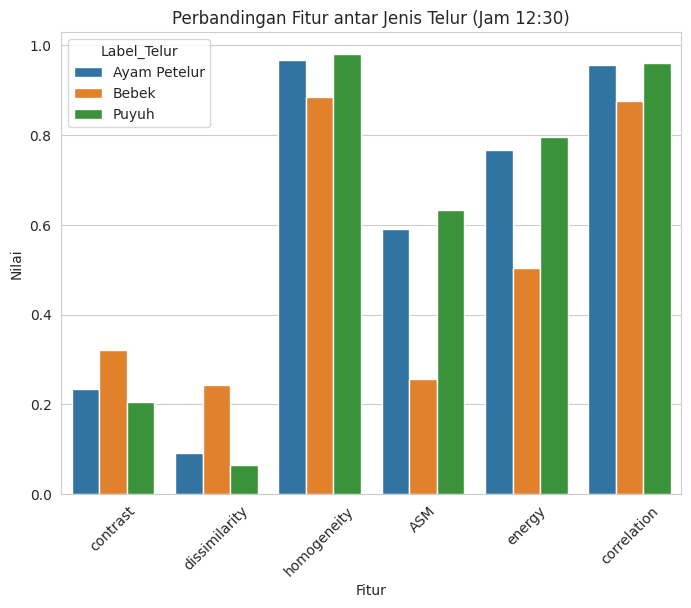

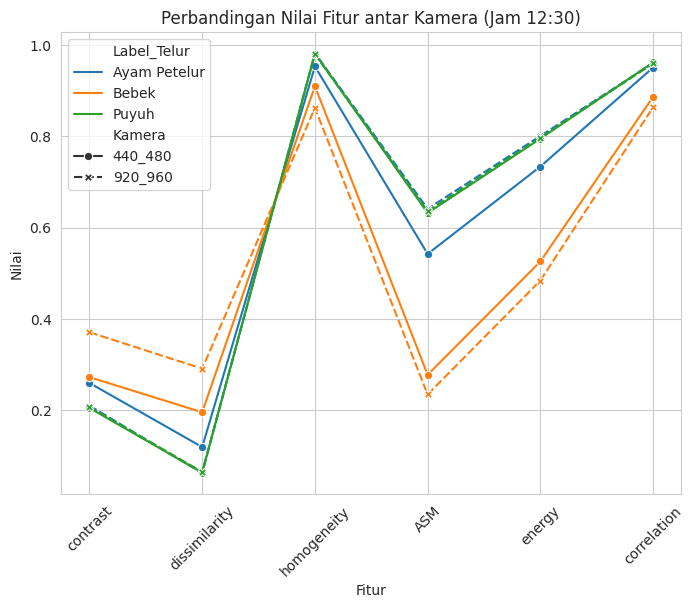

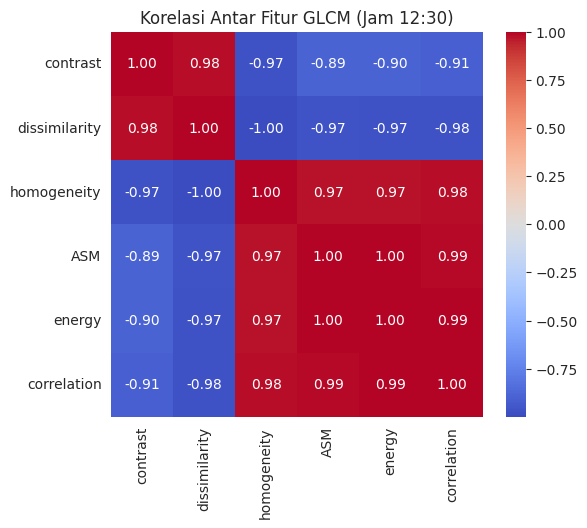

/tmp/ipython-input-2920192633.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted, x="Fitur", y="Nilai", hue="Label_Telur", ci=None)


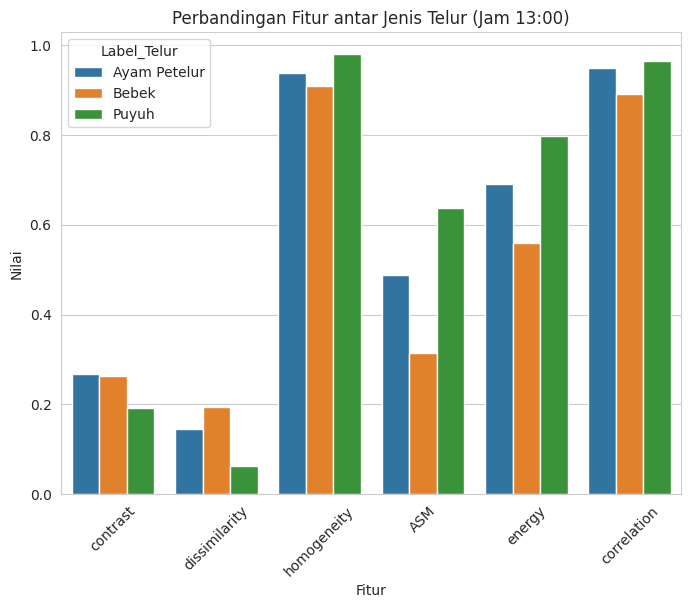

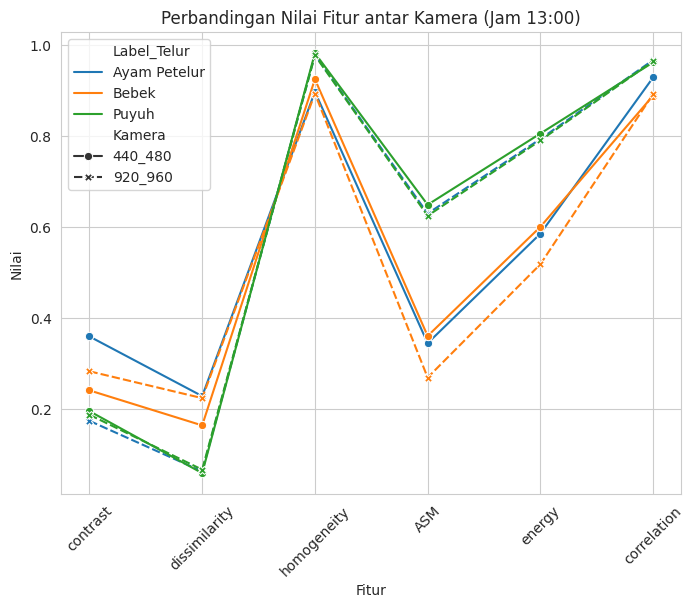

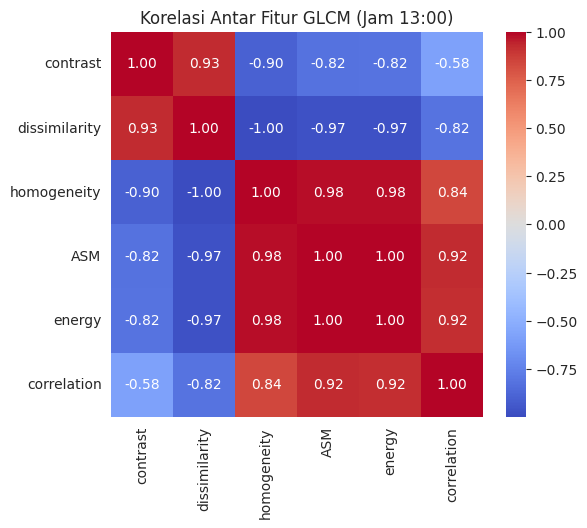

/tmp/ipython-input-2920192633.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted, x="Fitur", y="Nilai", hue="Label_Telur", ci=None)


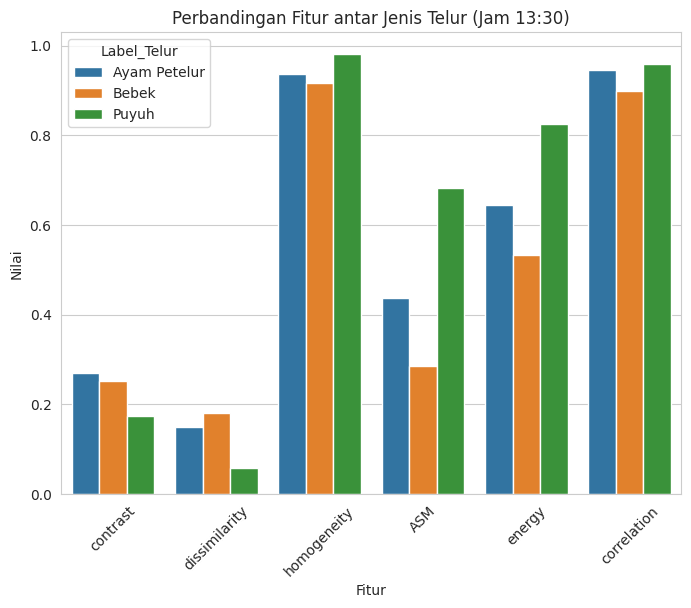

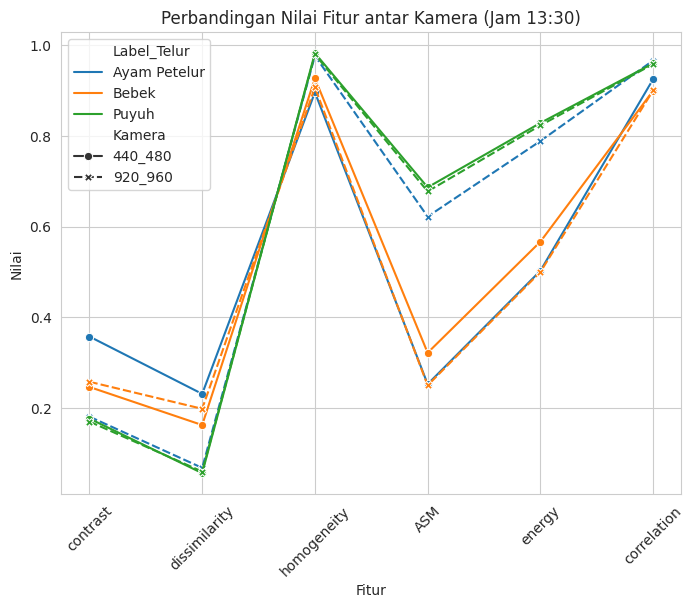

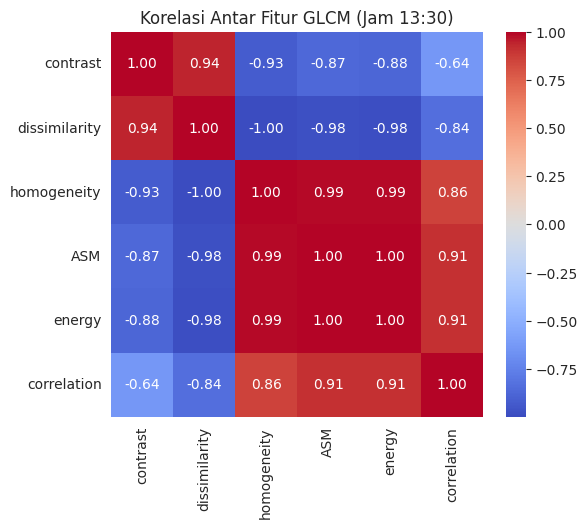

/tmp/ipython-input-2920192633.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted, x="Fitur", y="Nilai", hue="Label_Telur", ci=None)


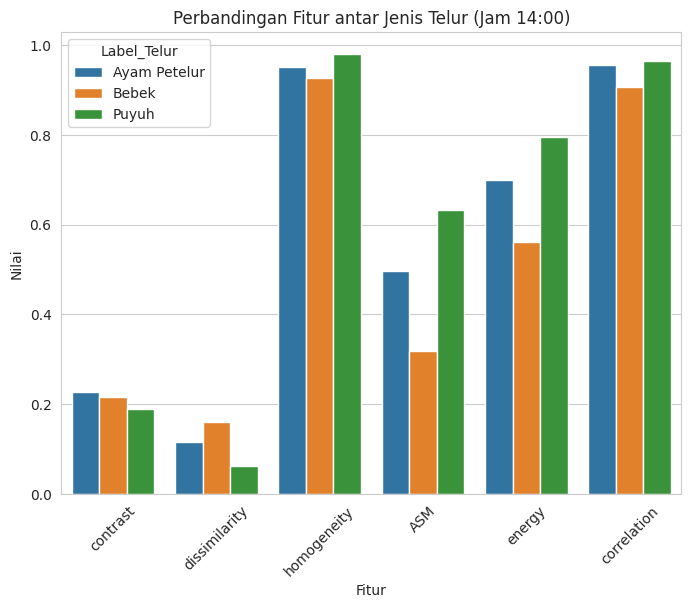

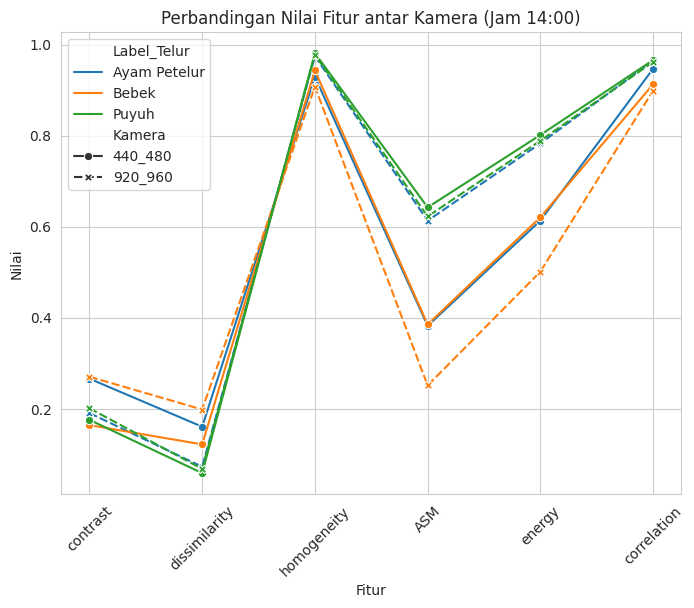

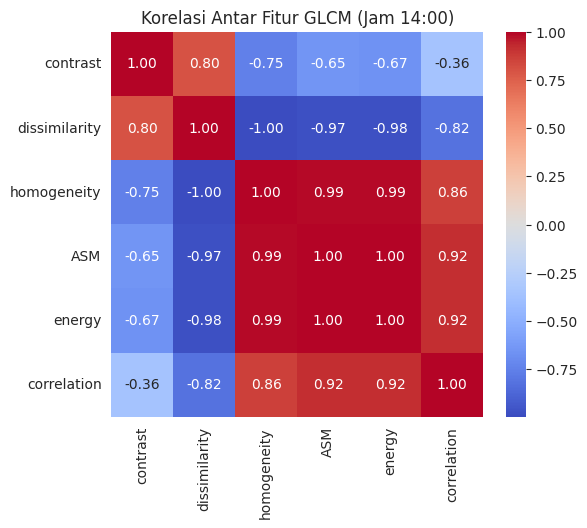

/tmp/ipython-input-2920192633.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted, x="Fitur", y="Nilai", hue="Label_Telur", ci=None)


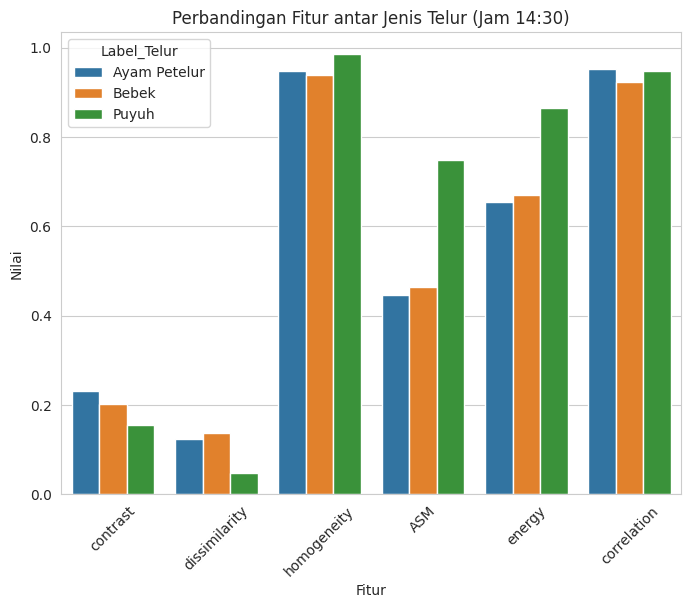

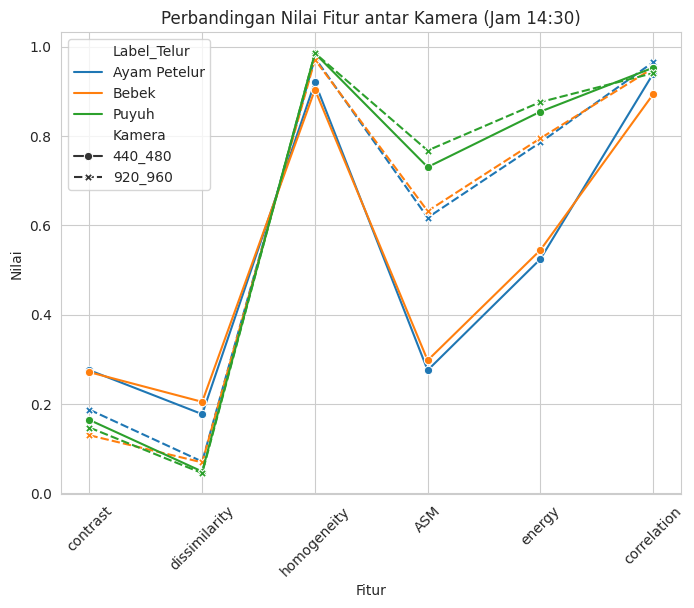

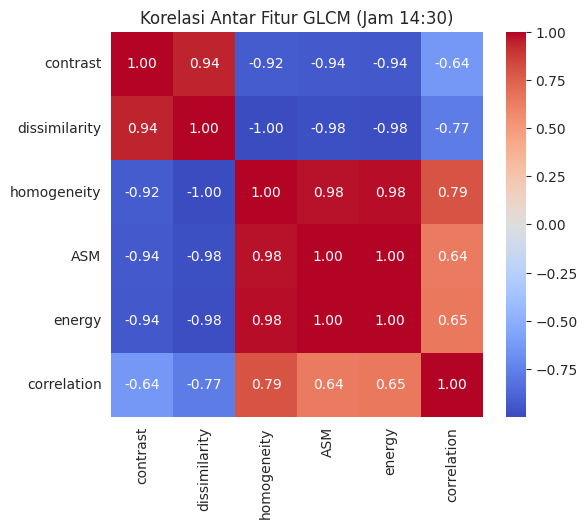

/tmp/ipython-input-2920192633.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted, x="Fitur", y="Nilai", hue="Label_Telur", ci=None)


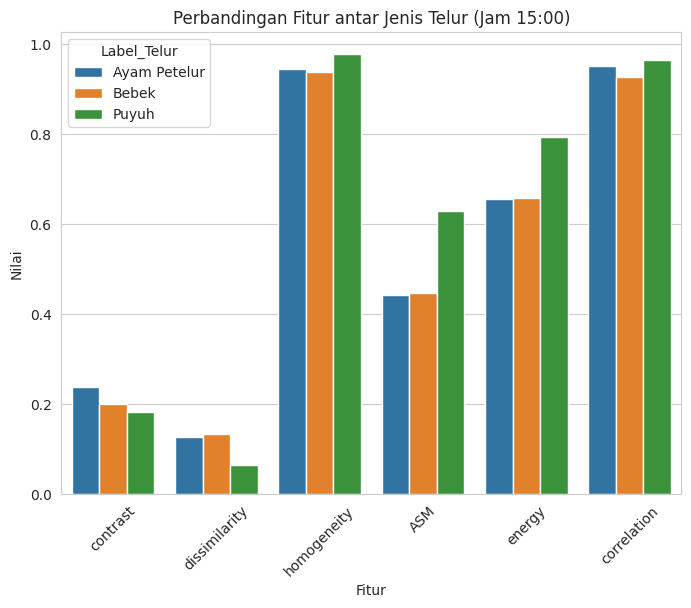

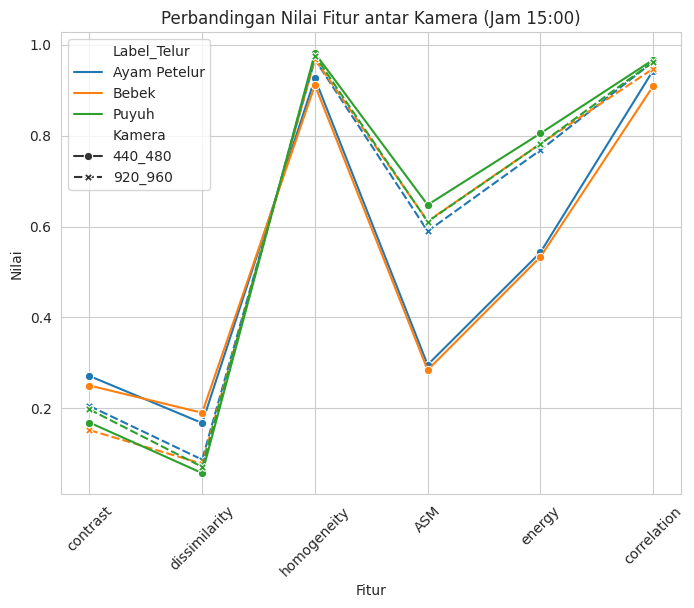

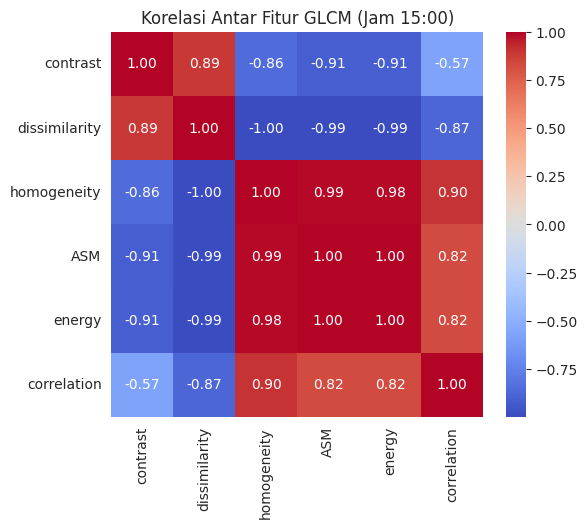

In [ ]:
visualisasi_per_jam(df_mean)


### Visualisasi Ekstraksi Berdasarkan Intensitas Cahaya

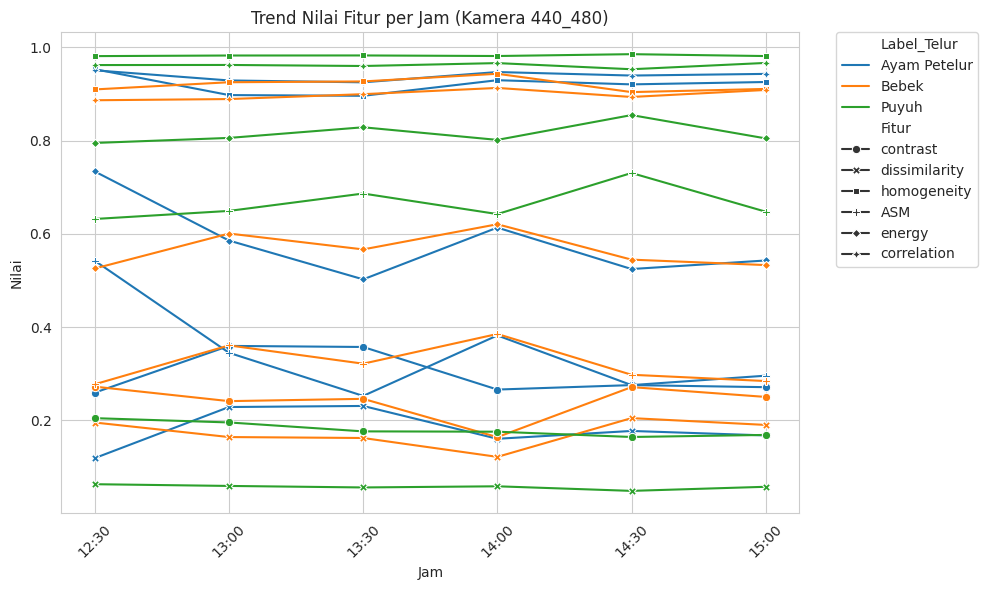

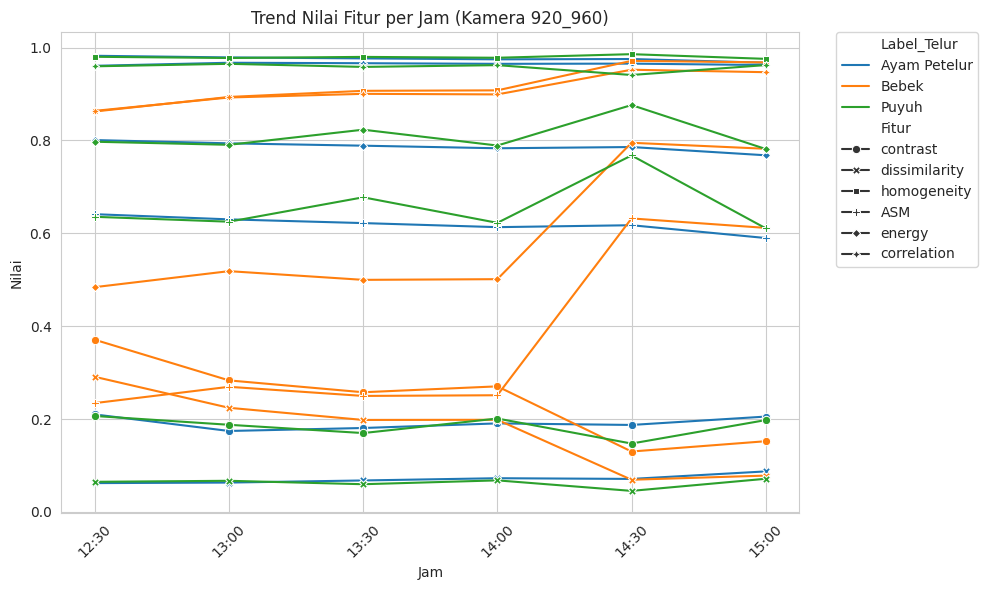

In [ ]:
visualisasi_per_kamera(df_mean)


**Perbandingan Antar Jenis Telur (Ayam, Bebek, Puyuh)**

1. Ayam Petelur <br>contrast sedang (0.21–0.36) → variasi tekstur kuning telur tidak terlalu ekstrem. <br>homogeneity menengah (0.89–0.97) → permukaan kuning telur agak rata tapi ada sedikit ketidakteraturan. <br> correlation relatif tinggi (0.92–0.97) → pola piksel kuning telur stabil dan konsisten. <br> Jadi tekstur halus tapi dengan sedikit variasi.

2. Bebek <br> contrast relatif tinggi (0.24–0.37, bahkan kadang 0.37 di 12:30 dengan cahaya terang). <br> homogeneity lebih rendah (0.86–0.94). <br> ASM/energy juga lebih rendah (0.23–0.38).  <br> Jadi kuning telur bebek permukaannya lebih kasar/tidak rata, lebih banyak variasi intensitas.

3. Puyuh <br> contrast terendah (0.16–0.20). <br> homogeneity dan ASM tertinggi (0.96–0.98 untuk homogeneity, 0.64–0.76 untuk ASM).<br> correlation stabil tinggi (0.95–0.97). <br> Jadi kuning telur puyuh paling halus, permukaan sangat homogen dan konsisten.
<br>

**Pengaruh Pencahayaan (Kamera 440_480 vs 920_960)**
<pre>
Kamera 440_480 (cahaya lebih rendah)
contrast cenderung lebih tinggi → tekstur terlihat lebih “kasar”.
homogeneity sedikit lebih rendah → detail lebih kelihatan.
Cocok kalau ingin menonjolkan variasi tekstur.

Kamera 920_960 (cahaya lebih terang)
contrast lebih rendah → permukaan terlihat lebih halus/seragam.
homogeneity lebih tinggi → kuning telur tampak rata.

Cocok untuk melihat konsistensi warna dan kelembutan kuning telur.

</pre>
Jadi, cahaya terang membuat permukaan kuning telur terlihat lebih homogen, sementara cahaya redup menonjolkan perbedaan tekstur.
<br>
<br>
**Pola Waktu (12:30–15:00)**

Tidak ada tren besar antar jam, tapi terlihat fluktuasi kecil:

Sekitar jam 13:00–13:30, beberapa nilai contrast Ayam naik (hingga 0.35), lalu turun lagi.

Puyuh relatif stabil sepanjang waktu (indikasi teksturnya memang paling konsisten).

Bebek lebih fluktuatif, terutama pada cahaya rendah.

Artinya kondisi pencahayaan lebih dominan daripada jam pengambilan.

# Training Model


In [ ]:
import os
import re
import pandas as pd

LABEL_MAP = {"ayampetelur": 0, "bebek": 1, "puyuh": 2}

# regex patterns
camera_re = re.compile(r'kamera[_\-]?([\d_]+)[_\-]?lx', flags=re.IGNORECASE)
time_re   = re.compile(r'(\d{1,2}[_\-]\d{2}|\d{3,4}|\d{1,2}:\d{2})')
label_re  = re.compile(r'(telur[_\-]?[a-z0-9_]+|ayam[_\-]?petelur|bebek|puyuh)', flags=re.IGNORECASE)

def normalize_time(raw):
    """Normalisasi waktu ke format HH:MM (string)."""
    if raw is None:
        return None
    s = str(raw)
    s = s.replace('-', '_')  # unify
    if ':' in s:
        # sudah HH:MM
        parts = s.split(':')
        h = int(parts[0]); m = parts[1]
        return f"{h:02d}:{m}"
    if '_' in s:
        a,b = s.split('_')
        return f"{int(a):02d}:{int(b):02d}"
    # 3 or 4 digits e.g. 1230 or 930
    if len(s) == 3:
        h = int(s[0]); m = s[1:]
        return f"{h:02d}:{m}"
    if len(s) == 4:
        h = int(s[:2]); m = s[2:]
        return f"{h:02d}:{m}"
    return None

def parse_filename(fname):
    """
    Parse filename seperti:
      kamera_440_480_lx_12_30_1_telur_ayam_petelur_1.jpg
    Return dict: {'camera':..., 'time':..., 'label_raw':..., 'label':..., 'label_key':...}
    """
    base = os.path.splitext(os.path.basename(fname))[0]  # tanpa ekstensi
    s = base.replace('-', '_')  # unify separator
    s_low = s.lower()

    # camera
    cam_m = camera_re.search(s_low)
    camera = None
    if cam_m:
        camera = cam_m.group(1)          # '440_480'
        camera = camera.replace('_', '_')  # keep underscore if needed

    # time
    time_m = time_re.search(s_low)
    time_raw = time_m.group(1) if time_m else None
    time_norm = normalize_time(time_raw) if time_raw else None

    # label (daerah yang berisi kata 'telur...' atau kata ayam/bebek/puyuh)
    label_m = label_re.search(s_low)
    label_raw = label_m.group(1) if label_m else None
    label_normalized = None
    label_key = None
    if label_raw:
        # bersihkan 'telur_' prefix bila ada
        lab = label_raw.replace('telur_', '').replace('telur-', '')
        lab = lab.replace('_','').replace('-','').strip()
        label_normalized = lab  # ex: 'ayampetelur' or 'bebek'
        label_key = lab
        # kalau label belum ada di LABEL_MAP, coba beberapa normalisasi
        if label_key not in LABEL_MAP:
            # beberapa heuristik: jika mengandung 'ayam' anggap 'ayampetelur'
            if 'ayam' in label_key and 'petelur' in label_key:
                label_key = 'ayampetelur'
            elif 'ayam' in label_key:
                label_key = 'ayampetelur'
            elif 'bebek' in label_key:
                label_key = 'bebek'
            elif 'puyuh' in label_key:
                label_key = 'puyuh'
            # else tetap None
    return {
        'camera': camera,
        'time_raw': time_raw,
        'time': time_norm,
        'label_raw': label_raw,
        'label_key': label_key
    }

# contoh penggunaan
fname = "kamera_440_480_lx_12_30_1_telur_ayam_petelur_1.jpg"
print(parse_filename(fname))
# output misal: {'camera':'440_480', 'time_raw':'12_30', 'time':'12:30', 'label_raw':'telur_ayam_petelur', 'label_key':'ayampetelur'}


{'camera': '440_480_', 'time_raw': '440', 'time': '04:40', 'label_raw': 'telur_ayam_petelur_1', 'label_key': 'ayampetelur'}


In [ ]:
def scan_folder_parse_names(image_dir):
    rows = []
    for root, dirs, files in os.walk(image_dir):
        for fn in files:
            if not fn.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tiff')):
                continue
            fp = os.path.join(root, fn)
            parsed = parse_filename(fn)
            lab = parsed['label_key']
            if lab is None or lab not in LABEL_MAP:
                # kalau label tidak terdeteksi, skip atau simpan sebagai 'unknown'
                # skip untuk training; Anda bisa juga disimpan untuk direview manual
                # print("skip (label gak terdeteksi):", fn)
                continue
            row = {
                'filepath': fp,
                'filename': os.path.relpath(fp, image_dir),
                'camera': parsed['camera'],
                'Jam': parsed['time'],
                'Label_Telur': lab,
                'label_type': LABEL_MAP[lab]
            }
            rows.append(row)
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.reset_index(drop=True)
    return df

# contoh pemakaian:
IMAGE_DIR = "/content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final"
df = scan_folder_parse_names(IMAGE_DIR)
print("samples:", len(df))
print(df.head())


samples: 2160
                                            filepath  \
0  /content/drive/MyDrive/Kuning Telur - CV/Datas...   
1  /content/drive/MyDrive/Kuning Telur - CV/Datas...   
2  /content/drive/MyDrive/Kuning Telur - CV/Datas...   
3  /content/drive/MyDrive/Kuning Telur - CV/Datas...   
4  /content/drive/MyDrive/Kuning Telur - CV/Datas...   

                                            filename    camera    Jam  \
0  Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelu...  440_480_  04:40   
1  Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelu...  440_480_  04:40   
2  Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelu...  440_480_  04:40   
3  Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelu...  440_480_  04:40   
4  Kamera 440 - 480 lx/12:30/1. Telur Ayam Petelu...  440_480_  04:40   

   Label_Telur   label_type  
0  ayampetelur  ayampetelur  
1  ayampetelur  ayampetelur  
2  ayampetelur  ayampetelur  
3  ayampetelur  ayampetelur  
4  ayampetelur  ayampetelur  


In [ ]:
import os
import pandas as pd

# Folder utama dataset
IMAGE_DIR = "/content/drive/MyDrive/Kuning Telur - CV/Dataset_preprocessing_Cleaned256_Final"

# Label map manual (opsional, bisa langsung dari nama folder juga)
LABEL_MAP = {"ayampetelur": "ayampetelur", "bebek": "bebek", "puyuh": "puyuh"}

rows = []
# Walk through the directories and files in the IMAGE_DIR
for root, dirs, files in os.walk(IMAGE_DIR):
    # Extract label name from folder name
    folder_name = os.path.basename(root).lower()
    label_name = None
    for key in LABEL_MAP.keys():
        if key in folder_name.replace(" ", ""): # remove spaces for matching
            label_name = key
            break

    if label_name is None:
        continue # skip if folder name doesn't match any label

    label_id = LABEL_MAP[label_name]

    for fn in files:
        if not fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            continue
        fp = os.path.join(root, fn)
        row = {
            "filepath": fp,
            "filename": fn,
            "Label_Telur": label_name,
            "label_type": label_id,
        }
        rows.append(row)

df = pd.DataFrame(rows)
print("Total sampel:", len(df))
print(df["Label_Telur"].value_counts())

# Simpan ke CSV
SAVE_PATH = "/content/drive/MyDrive/Kuning Telur - CV/datasetwkwk.csv"
df.to_csv(SAVE_PATH, index=False)
print("Saved:", SAVE_PATH)

Total sampel: 0


KeyError: 'Label_Telur'

In [6]:
"""
train_type_only.py
"""

import os
import sys
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# ---------- GANTI JIKA PAKAI COLAB / JUPYTER ----------
DEFAULT_NOTEBOOK_CSV_PATH = '/content/drive/MyDrive/Kuning Telur - CV/dataset_index.csv'
# ----------------------------------------------------

def _argv_has_csv(argv):
    for a in argv:
        if a == '--csv' or a.startswith('--csv='):
            return True
    return False

def get_args():
    parser = argparse.ArgumentParser(description="Train yolk TYPE classification (MobileNetV2)")
    parser.add_argument('--csv', type=str, required=True, help="Path to dataset_index.csv")
    parser.add_argument('--model_dir', type=str, default="/content/drive/MyDrive/Kuning Telur - CV/Model/ModelCNN_3")
    parser.add_argument('--img_size', type=int, default=224)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--epochs', type=int, default=30)
    parser.add_argument('--random_state', type=int, default=42)
    parser.add_argument('--no_prefetch', action='store_true')
    parser.add_argument('--finetune_after', type=int, default=0)

    in_notebook = 'ipykernel' in sys.modules or 'google.colab' in sys.modules
    if in_notebook:
        if _argv_has_csv(sys.argv):
            args, _ = parser.parse_known_args()
        else:
            notebook_argv = [
                '--csv', DEFAULT_NOTEBOOK_CSV_PATH,
                '--epochs', '30'
            ]
            args, _ = parser.parse_known_args(notebook_argv)
    else:
        args = parser.parse_args()
    return args

args = get_args()

CSV_PATH = args.csv
MODEL_DIR = args.model_dir
IMG_SIZE = (args.img_size, args.img_size)
BATCH_SIZE = args.batch_size
EPOCHS = args.epochs
RANDOM_STATE = args.random_state
AUTOTUNE = tf.data.AUTOTUNE if not args.no_prefetch else None
FINETUNE_AFTER = args.finetune_after

os.makedirs(MODEL_DIR, exist_ok=True)

LABEL_MAP = {"ayampetelur": 0, "bebek": 1, "puyuh": 2}

# -------------------- Load dataset ----------------------
df = pd.read_csv(CSV_PATH)
required_cols = ['filepath', 'Label_Telur']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"CSV harus ada kolom '{c}'")

df = df[df['Label_Telur'].isin(LABEL_MAP.keys())].copy()
df['label'] = df['Label_Telur'].map(LABEL_MAP).astype('int32')

print("Samples total:", len(df))
print(df['Label_Telur'].value_counts())

# -------------------- Stratified split -------------------
train_df, test_df = train_test_split(df, test_size=0.15,
                                     stratify=df['label'],
                                     random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_df, test_size=0.15,
                                    stratify=train_df['label'],
                                    random_state=RANDOM_STATE)

# -------------------- Dataset pipeline -------------------
def df_to_tf_dataset(df_local, shuffle=True):
    filepaths = df_local['filepath'].astype(str).values
    labels = df_local['label'].astype('int32').values
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    def _load(fp, lbl):
        img = tf.io.read_file(fp)
        img = tf.io.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)  # rentang 0..255
        return img, lbl

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE if AUTOTUNE else 1)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=RANDOM_STATE)
    ds = ds.batch(BATCH_SIZE)
    if AUTOTUNE:
        ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = df_to_tf_dataset(train_df, shuffle=True)
val_ds = df_to_tf_dataset(val_df, shuffle=False)
test_ds = df_to_tf_dataset(test_df, shuffle=False)

# -------------------- Model builder ----------------------
def get_augmentation():
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.04),
        layers.RandomZoom(0.05),
        layers.RandomTranslation(0.02, 0.02),
        layers.RandomContrast(0.08),
    ], name="augmentation")

def build_model(num_classes=3):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3), dtype=tf.float32)
    x = get_augmentation()(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model, base

model, backbone = build_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

# -------------------- Class weights ----------------------
y_train = train_df['label'].values
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

# -------------------- Callbacks --------------------------
ckpt_path = os.path.join(MODEL_DIR, "best_type_model.h5")
cbs = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)
]

# -------------------- Training ---------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs,
    class_weight=class_weight_dict
)

# -------------------- Optional Fine-tune -----------------
if FINETUNE_AFTER and FINETUNE_AFTER < EPOCHS:
    backbone.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
    )
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FINETUNE_AFTER,
        callbacks=cbs,
        class_weight=class_weight_dict
    )

# -------------------- Evaluate ---------------------------
eval_res = model.evaluate(test_ds)
print("Eval results (loss, accuracy):", eval_res)

# -------------------- Save final model -------------------
final_model_path = os.path.join(MODEL_DIR, "final_type_model.h5")
print("Saving final model to:", final_model_path)
model.save(final_model_path)
print("Selesai. Model disimpan ke", final_model_path)


Samples total: 1080
Label_Telur
ayampetelur    360
bebek          360
puyuh          360
Name: count, dtype: int64
Class weights: {0: 1.0, 1: 1.0, 2: 1.0}
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4236 - loss: 1.2612

25/25 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.4259 - loss: 1.2569 - val_accuracy: 0.5145 - val_loss: 0.8203 - learning_rate: 1.0000e-04
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6765 - loss: 0.7330

25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.6784 - loss: 0.7303 - val_accuracy: 0.8478 - val_loss: 0.5059 - learning_rate: 1.0000e-04
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8376 - loss: 0.4203

25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8377 - loss: 0.4201 - val_accuracy: 0.9565 - val_loss: 0.3382 - learning_rate: 1.0000e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8706 - loss: 0.3407

25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8708 - loss: 0.3405 - val_accuracy: 1.0000 - val_loss: 0.2277 - learning_rate: 1.0000e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9079 - loss: 0.2813 - val_accuracy: 1.0000 - val_loss: 0.1638 - learning_rate: 1.0000e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9320 - loss: 0.1918 - val_accuracy: 1.0000 - val_loss: 0.1228 - learning_rate: 1.0000e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9522 - loss: 0.1853 - val_accuracy: 1.0000 - val_loss: 0.0943 - learning_rate: 1.0000e-04
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9449 - loss: 0.1654 - val_accuracy: 1.0000 - val_loss: 0.0739 - learning_rate: 1.0000e-04
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9576 - loss: 0.1306 - val_accuracy: 1.0000 - val_loss: 0.0606 - learning_rate: 1.0000e-04
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9542 - loss: 0.1525 - 

Eval results (loss, accuracy): [0.2560643255710602, 1.0]
Saving final model to: /content/drive/MyDrive/Kuning Telur - CV/Model/ModelCNN_3/final_type_model.h5
Selesai. Model disimpan ke /content/drive/MyDrive/Kuning Telur - CV/Model/ModelCNN_3/final_type_model.h5


/tmp/ipython-input-267344810.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-267344810.py:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


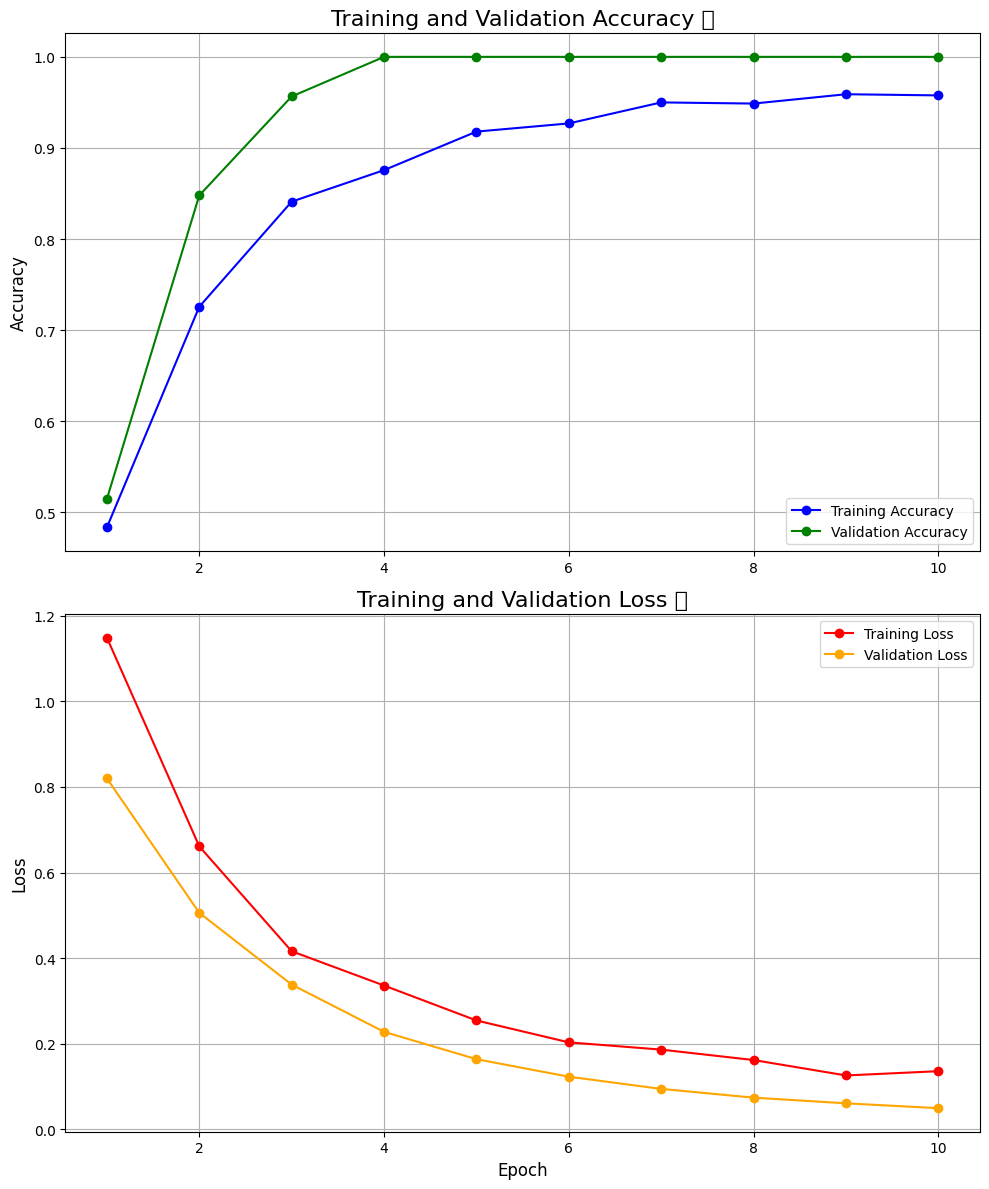

In [10]:
import matplotlib.pyplot as plt

# Ambil history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc)+1)

# Buat 2 subplot vertikal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # lebar 10, tinggi 12

ax1.plot(epochs_range, acc, 'o-', label='Training Accuracy', color='b')
ax1.plot(epochs_range, val_acc, 'o-', label='Validation Accuracy', color='g')
ax1.set_title('Training and Validation Accuracy 📈', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(epochs_range, loss, 'o-', label='Training Loss', color='r')
ax2.plot(epochs_range, val_loss, 'o-', label='Validation Loss', color='orange')
ax2.set_title('Training and Validation Loss 📉', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()


Confusion Matrix:
 [[54  0  0]
 [ 0 54  0]
 [ 0  0 54]]


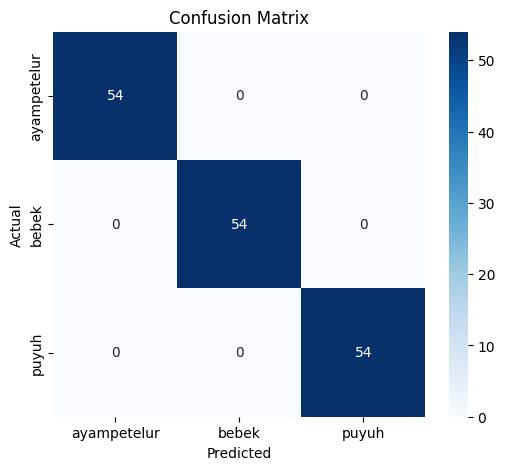


Classification Report:
              precision    recall  f1-score   support

 ayampetelur       1.00      1.00      1.00        54
       bebek       1.00      1.00      1.00        54
       puyuh       1.00      1.00      1.00        54

    accuracy                           1.00       162
   macro avg       1.00      1.00      1.00       162
weighted avg       1.00      1.00      1.00       162



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Ambil semua data test
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Plot pakai seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(LABEL_MAP.keys()),
            yticklabels=list(LABEL_MAP.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(LABEL_MAP.keys())))
